In [42]:
import os
import anndata as ad
import umap
import scipy as sip
from scipy import sparse
from sklearn import preprocessing
import scanpy as scp
import pickle
import pandas as pd
import numpy as np
import igraph as ig
import seaborn as sb
import snf
import sklearn as skl
from sklearn import cluster
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import v_measure_score
from snf import compute, metrics
import matplotlib.pyplot as plt
from PyComplexHeatmap import *
from collections import Counter
import math

In [43]:
data = os.path.abspath(os.path.join(os.getcwd(),"../data"))

input = os.path.join(data, "input")
output = os.path.join(data, "output")

complementary = os.path.join(input, "complementary")

shared = os.path.join(output, "shared_info_74")


level1 = os.path.join(output, "level1")
level2 = os.path.join(output, "level2")
level3 = os.path.join(output, "level3")

original = os.path.join(input, "original")
analysis_input = os.path.join(output, "analysis_input")

In [45]:
with open(os.path.join(level1, 'fusions.pickle'), 'rb') as f:
    level1_fusions = pickle.load(f)
with open(os.path.join(level2, 'fusions.pickle'), 'rb') as f:
    level2_fusions = pickle.load(f)
with open(os.path.join(level3, 'fusions.pickle'), 'rb') as f:
    level3_fusions = pickle.load(f)


with open(os.path.join(level1, 'cluster_info.pickle'), 'rb') as f:
    level1_cluster_info = pickle.load(f)
with open(os.path.join(level2, 'cluster_info.pickle'), 'rb') as f:
    level2_cluster_info = pickle.load(f)
with open(os.path.join(level3, 'cluster_info.pickle'), 'rb') as f:
    level3_cluster_info = pickle.load(f)

with open(os.path.join(level1, 'cluster_info.pickle'), 'rb') as f:
    level1_cluster_info = pickle.load(f)
with open(os.path.join(level2, 'cluster_info.pickle'), 'rb') as f:
    level2_cluster_info = pickle.load(f)
with open(os.path.join(level3, 'cluster_info.pickle'), 'rb') as f:
    level3_cluster_info = pickle.load(f)


with open(os.path.join(level1, 'predictions.pickle'), 'rb') as f:
    level1_predictions = pickle.load(f)
with open(os.path.join(level2, 'predictions.pickle'), 'rb') as f:
    level2_predictions = pickle.load(f)
with open(os.path.join(level3, 'predictions.pickle'), 'rb') as f:
    level3_predictions  = pickle.load(f)


with open(os.path.join(level1, "graphs_74.pickle"), "rb") as f:
    level1_graphs = pickle.load(f)
with open(os.path.join(level2, "graphs_74.pickle"), "rb") as f:
    level2_graphs = pickle.load(f)
with open(os.path.join(level3, "graphs_74.pickle"), "rb") as f:
    level3_graphs = pickle.load(f)

In [46]:
with open(os.path.join(level1, "noise_kernel_PSNs.pickle"), "rb") as f:
    noise_kernel_PSNs = pickle.load(f) 

with open(os.path.join(level1, "kernel_PSNs.pickle"), "rb") as f:
    level1_kernel_PSNs = pickle.load(f) 
with open(os.path.join(level2, "kernel_PSNs.pickle"), "rb") as f:
    level2_kernel_PSNs = pickle.load(f) 
with open(os.path.join(level3, "kernel_PSNs.pickle"), "rb") as f:
    level3_kernel_PSNs = pickle.load(f) 


with open(os.path.join(level1, "correlations.pickle"), "rb") as f:
    level1_correlations = pickle.load(f) 
with open(os.path.join(level2, "correlations.pickle"), "rb") as f:
    level2_correlations = pickle.load(f) 
with open(os.path.join(level3, "correlations.pickle"), "rb") as f:
    level3_correlations = pickle.load(f) 



with open(os.path.join(level1, "knn_PSNs.pickle"), "rb") as f:
    level1_knn_PSNs = pickle.load(f) 
with open(os.path.join(level2, "knn_PSNs.pickle"), "rb") as f:
    level2_knn_PSNs = pickle.load(f) 
with open(os.path.join(level3, "knn_PSNs.pickle"), "rb") as f:
    level3_knn_PSNs = pickle.load(f)


with open(os.path.join(level1, "noise_and_none_noise_combined.pickle"), "rb") as f:
    level1_all = pickle.load(f)
with open(os.path.join(level1, "weights_ALL.pickle"), "rb") as f:
    weights = pickle.load(f) 
with open(os.path.join(level1, "noise_graphs_74.pickle"), "rb") as f:
    noise_74 = pickle.load(f) 

In [47]:
with open(os.path.join(shared, "patients_74.pickle"), "rb") as f:
    patients_74 = pickle.load(f) 
with open(os.path.join(shared, "ground_truth_d.pickle"), "rb") as f:
    gt_d = pickle.load(f) 
with open(os.path.join(shared, "ground_truth_dg.pickle"), "rb") as f:
    gt_dg = pickle.load(f) 
with open(os.path.join(shared, "id_to_name.pickle"), "rb") as f:
    id_to_name = pickle.load(f) 

In [48]:
module_info = {'IFN': ['G77', 'G151', 'G54', 'G48', 'G101', 'G112', 'G17'],
 'AP1': ['G39', 'G114', 'G18', 'G92', 'G50', 'G65', 'G79'],
 'cycling': ['G96', 'G38', 'G19', 'G123', 'G80', 'G148'],
 'C19': ['G56', 'G73', 'G12', 'G122', 'G105'],
 'ZNF': ['G55', 'G110', 'G91', 'G72', 'G15', 'G45']}

In [49]:
transform = "wot"
write_path = analysis_input + "/" + transform

In [53]:
panelize_reward_d = []
panelize_reward_dg = []

for i in patients_74:
    panelize_reward_d_ij = []
    panelize_reward_dg_ij = []

    d1 = level1_graphs["G0"][i].obs.Disease[0]
    dg1 = level1_graphs["G0"][i].obs.DiseaseGroup[0]

    for j in patients_74:
        d2 = level1_graphs["G0"][j].obs.Disease[0]
        dg2 = level1_graphs["G0"][j].obs.DiseaseGroup[0]

        if d1 == d2:
            panelize_reward_d_ij.append(1)
        else:
            panelize_reward_d_ij.append(-1)

        if dg1 == dg2:
            panelize_reward_dg_ij.append(1)
        elif dg1 == "Healthy" or dg2 == "Healthy":
            panelize_reward_dg_ij.append(-2)
        else:
            panelize_reward_dg_ij.append(-1)

    panelize_reward_d.append(panelize_reward_d_ij)
    panelize_reward_dg.append(panelize_reward_dg_ij)


for i in range(len(panelize_reward_dg)):
    panelize_reward_d[i][i] = 0
    panelize_reward_dg[i][i] = 0

panelize_reward_d = np.array(panelize_reward_d, dtype="float64")
panelize_reward_dg = np.array(panelize_reward_dg, dtype="float64")

def make_transition_matrix(fused_network):
    tm = []
    for i, row in enumerate(fused_network):
        tm.append(row/ sum(row))
    return tm

def random_walker_objective(transition_matrix):
    d_score = (transition_matrix * panelize_reward_d).sum()
    dg_score = (transition_matrix * panelize_reward_dg).sum()
    #score = 0.5 * d_score + 0.5 * dg_score
    score =  dg_score
    return d_score, dg_score, score

The majority vote approach. <br>
The disease group predicted for all patients in a cluster = The disease group of at least 70% of the patients in that cluster <br>
The disease predicted for all patients in a cluster = The disease of at least 50% of the patients in that cluster <br>

In [54]:
def labels(cluster_assignment, mode = "d"):
    if mode == "d":
        gt = list(gt_d.values())
        t = 0.5
    else:
        gt = list(gt_dg.values())
        t = 0.7

    cluster_memberships = {str(c): [] for c in set(cluster_assignment)} # This dictionary will contain information on 
    for i in range(len(patients_74)):
        assigned_c = str(cluster_assignment[i])
        actual_disease = gt[i]
        cluster_memberships[assigned_c].append(actual_disease)

    cluster_labels = {} 
    for c, cluster_members in cluster_memberships.items():
        num_members = len(cluster_members)
        threshold = math.ceil(num_members * t)
        cluster_label = "None"
        member_counts = Counter(cluster_members) # This dictionary will contain the following info  ->   disease label : count
        for member, count in member_counts.items():
            if count >= threshold:
                cluster_label = member
        cluster_labels[c] = cluster_label

    preds = []
    correct = 0

    for i, c in enumerate(cluster_assignment):
        c = str(c)
        predicted_label = cluster_labels[c]
        if predicted_label == "None":
            preds.append(-1) # Label could not be determined
        else:
            preds.append(predicted_label)
  
        if gt[i] == predicted_label:
            correct+=1
    

    return preds, correct/len(patients_74)

# Negative Control

In [55]:
number_to_modality_new = {}
number_to_module_new = {}
all_kernel_psns = level1_all["kernel_psns"]

for i, id in enumerate(level1_all["names"]):
    if id.find("N") >= 0:
        number_to_module_new[i] = "Noise"
        number_to_modality_new[i] = noise_74[id].uns["modality"]
    else:
        number_to_modality_new[i] = level1_graphs[id].uns["modality"]
        number_to_module_new[i] = level1_graphs[id].uns["module"]


df_row = pd.DataFrame(number_to_modality_new.values(), columns=["modality"]).join(pd.DataFrame(number_to_module_new.values(), columns=["module"]) )
df_column = pd.DataFrame(number_to_modality_new.values(), columns=["modality"]).join(pd.DataFrame(number_to_module_new.values(), columns=["module"]) )


row_colors_dict = {"module":{"None": "grey", "IFN": "blue", "C19": "red", "cycling": "orange", "ZNF": "green", "AP1": "purple", "Noise": "cyan" },
                  "modality":{"citeRNA":"skyblue", "bulkRNA": "darkorange" , "cytof": "wheat", "adt": "darkgray", "luminex": "orangered", "facs": "yellowgreen" }  }

row_ha = HeatmapAnnotation(Modality=anno_simple(df_row.modality,colors=row_colors_dict['modality'],rasterized=True),
                           Module=anno_simple(df_row.module,colors=row_colors_dict['module'],rasterized=True),
                           axis=0)

col_ha= HeatmapAnnotation(Modality=anno_simple(df_column.modality,colors=row_colors_dict['modality'],rasterized=True),
                          Module=anno_simple(df_column.module,colors=row_colors_dict['module'],rasterized=True),
                          axis=1)

## Similarity of Noise and Kernel PSNs

In [57]:
correlation_similarity = []

for g1 in level1_all["kernel_psns"]:
    corr_with_g1 = []
    g1 = g1.flatten()
    for g2 in level1_all["kernel_psns"]:
        g2 = g2.flatten()
        pearson = np.corrcoef(g1,g2)[0,1]
        corr_with_g1.append(pearson)
    correlation_similarity.append(corr_with_g1)

correlation_similarity = np.array(correlation_similarity)
correlation_similarity_with_names = pd.DataFrame(correlation_similarity, index= level1_all["names"], columns= level1_all["names"])
correlation_similarity = pd.DataFrame(correlation_similarity)

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..


/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/PyComplexHeatmap/clustermap.py:803: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/PyComplexHeatmap/clustermap.py:803: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/PyComplexHeatmap/clustermap.py:803: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/PyComplexHeatmap/clustermap.py:803: UserWarning: Cluster

Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..


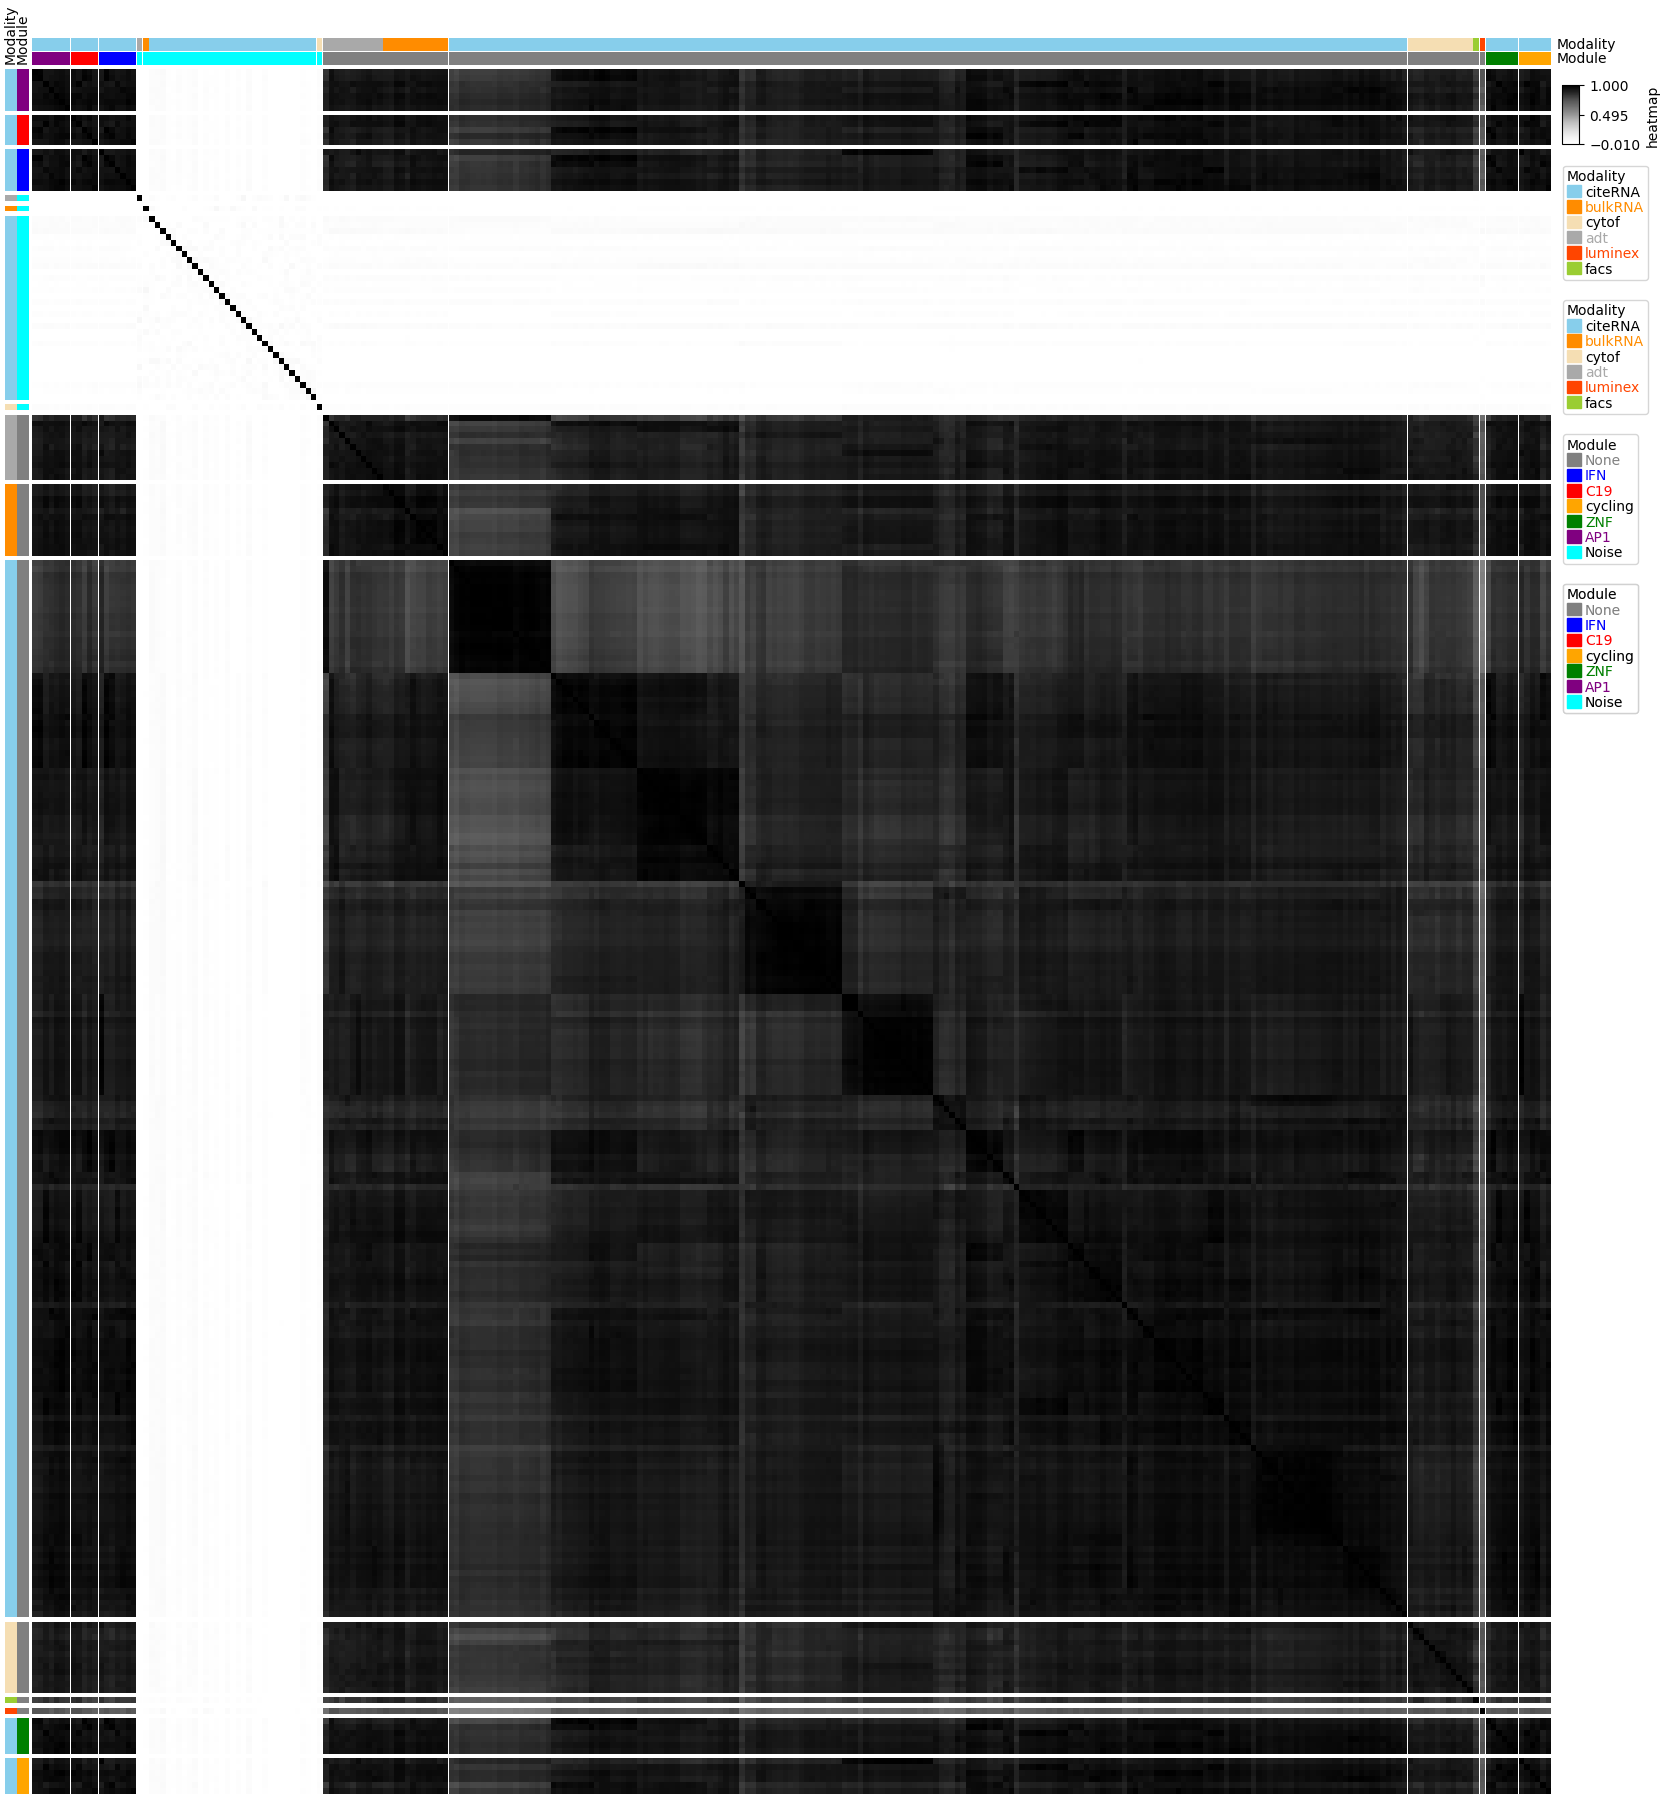

In [58]:
fig, ax = plt.subplots(figsize=(20,20))
nc1 = ClusterMapPlotter(data=pd.DataFrame(correlation_similarity_with_names.to_numpy(), index = list(number_to_module_new.keys()), columns =  list(number_to_module_new.keys())), top_annotation=col_ha, left_annotation=row_ha,
                     show_rownames=False,show_colnames=False,
                     row_dendrogram=False,col_dendrogram=False,
                     row_split=df_row.loc[:, ['module', 'modality']],
                     col_split=df_column.loc[:, ['module', 'modality']],
                     cmap='Greys',
                     rasterized=True,row_split_gap=1,legend=True,legend_anchor='ax_heatmap',legend_vpad=5)

In [59]:
fig.savefig(os.path.join(write_path, "nc_Kernel"))

## Similarity of Noise and KNN PSNs

In [60]:
correlation_similarity = []

for g1 in level1_all["knn_psns"]:
    corr_with_g1 = []
    g1 = g1.flatten()
    for g2 in level1_all["knn_psns"]:
        g2 = g2.flatten()
        pearson = np.corrcoef(g1,g2)[0,1]
        corr_with_g1.append(pearson)
    correlation_similarity.append(corr_with_g1)

correlation_similarity = np.array(correlation_similarity)
correlation_similarity_with_names = pd.DataFrame(correlation_similarity, index= level1_all["names"], columns= level1_all["names"])
correlation_similarity = pd.DataFrame(correlation_similarity)

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..


/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/PyComplexHeatmap/clustermap.py:803: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/PyComplexHeatmap/clustermap.py:803: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/PyComplexHeatmap/clustermap.py:803: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/PyComplexHeatmap/clustermap.py:803: UserWarning: Cluster

Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..


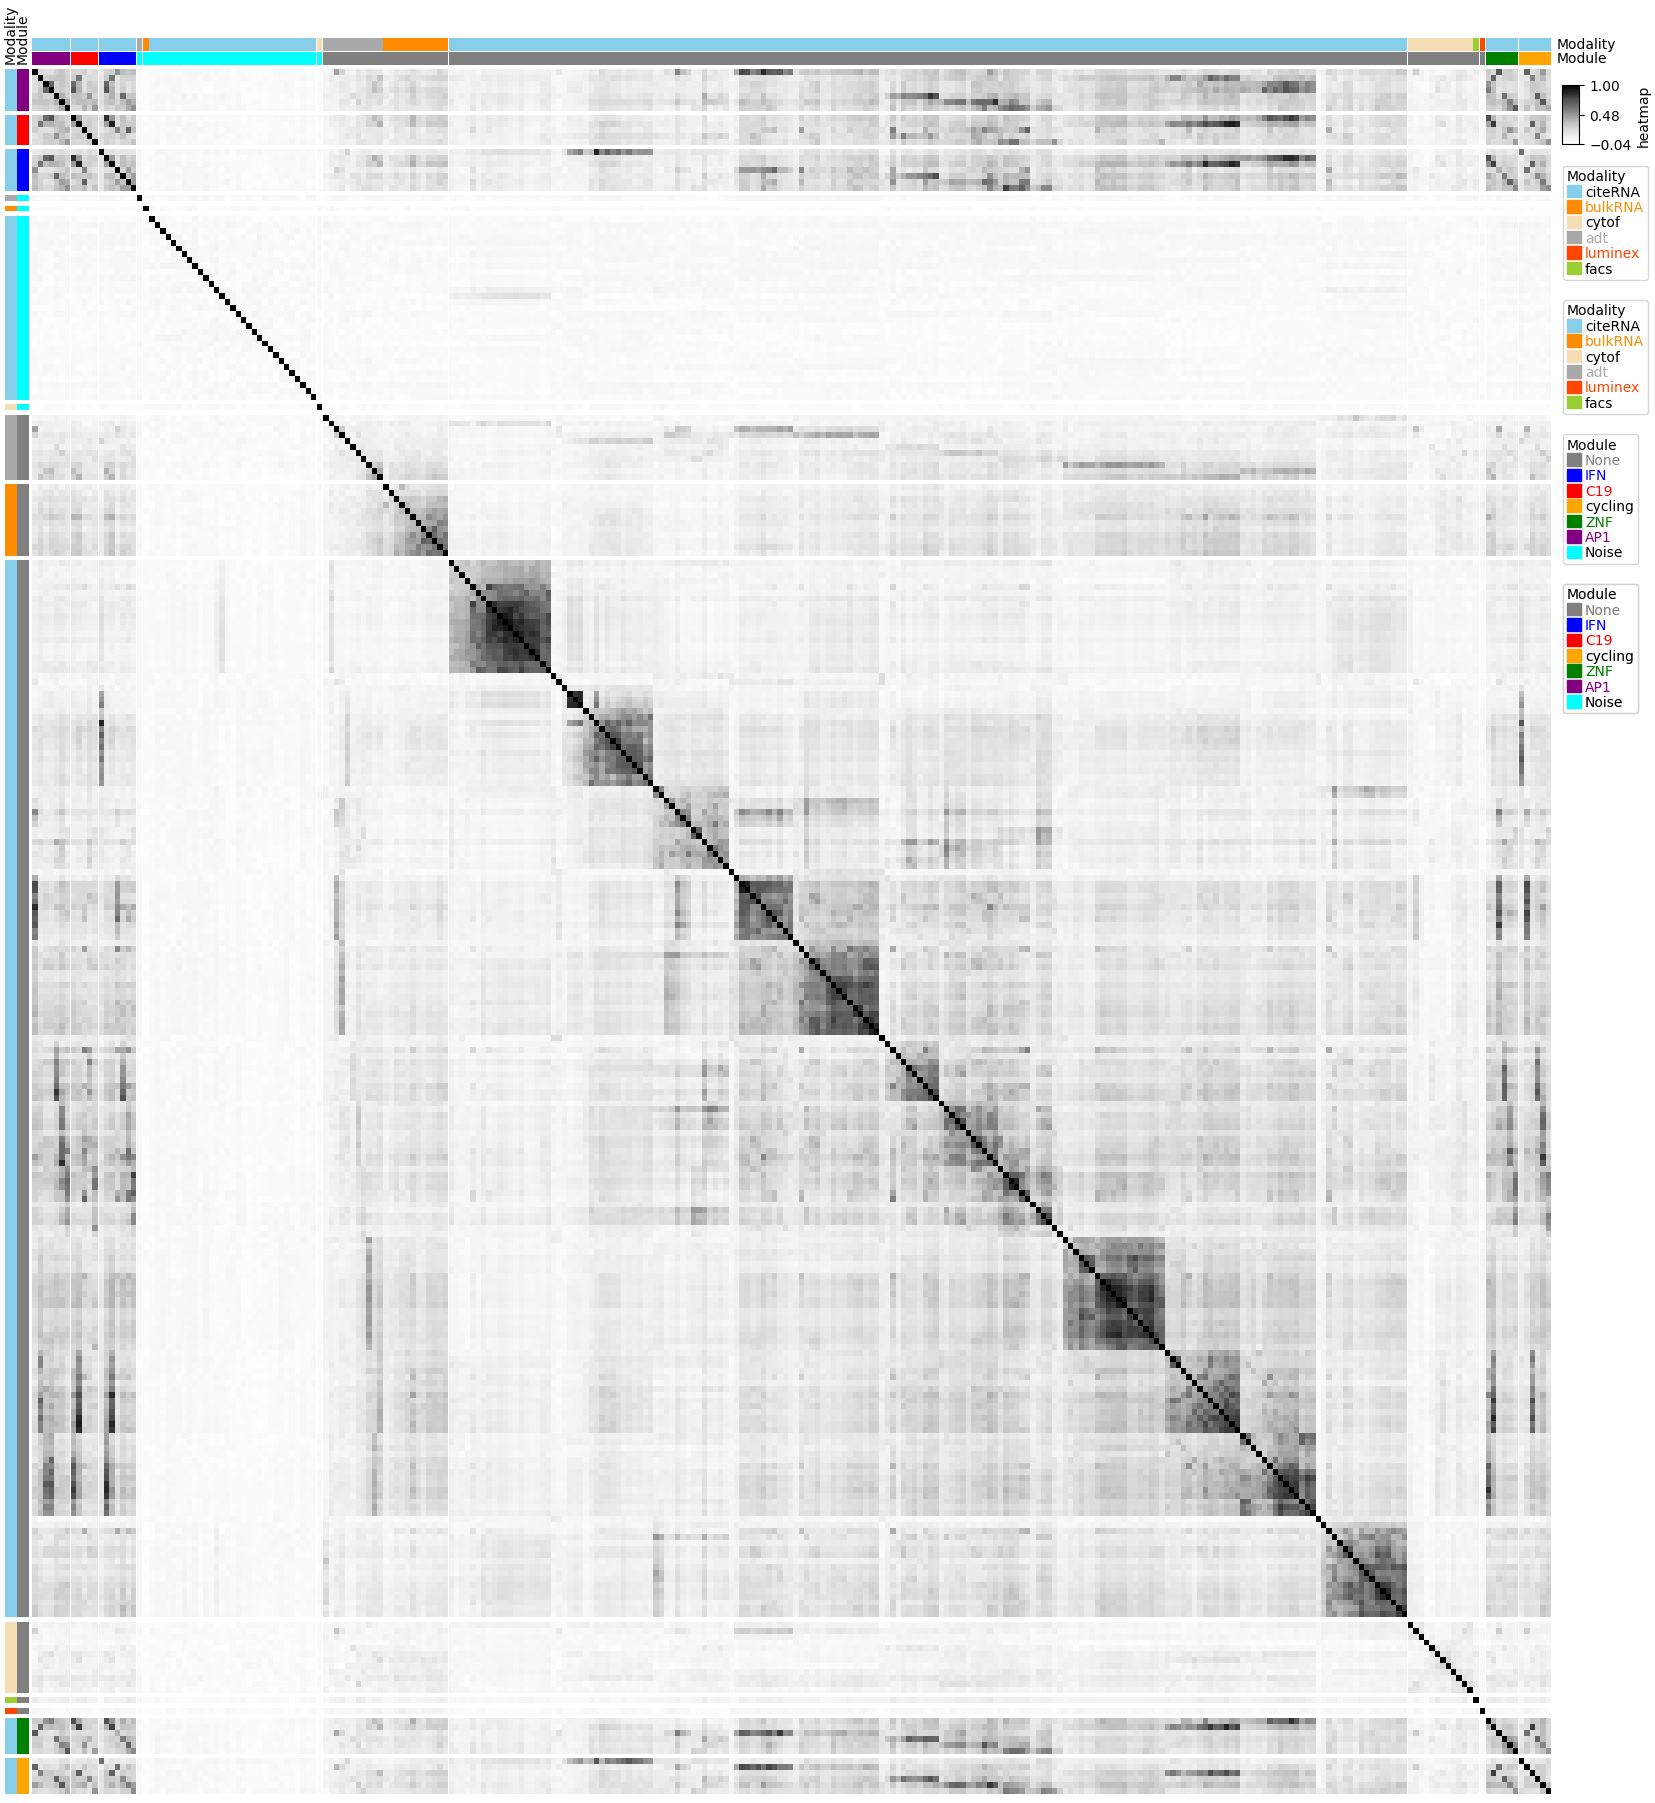

In [61]:

fig, ax = plt.subplots(figsize=(20,20))
nc2 = ClusterMapPlotter(data=pd.DataFrame(correlation_similarity_with_names.to_numpy(), index = list(number_to_module_new.keys()), columns =  list(number_to_module_new.keys())), top_annotation=col_ha, left_annotation=row_ha,
                     show_rownames=False,show_colnames=False,
                     row_dendrogram=False,col_dendrogram=False,
                     row_split=df_row.loc[:, ['module', 'modality']],
                     col_split=df_column.loc[:, ['module', 'modality']],
                     cmap='Greys',
                     rasterized=True,row_split_gap=1,legend=True,legend_anchor='ax_heatmap',legend_vpad=5)

In [62]:
fig.savefig(os.path.join(write_path, "nc_KNN"))

## Similarity of Modalities in L1

### KNN

<Axes: >

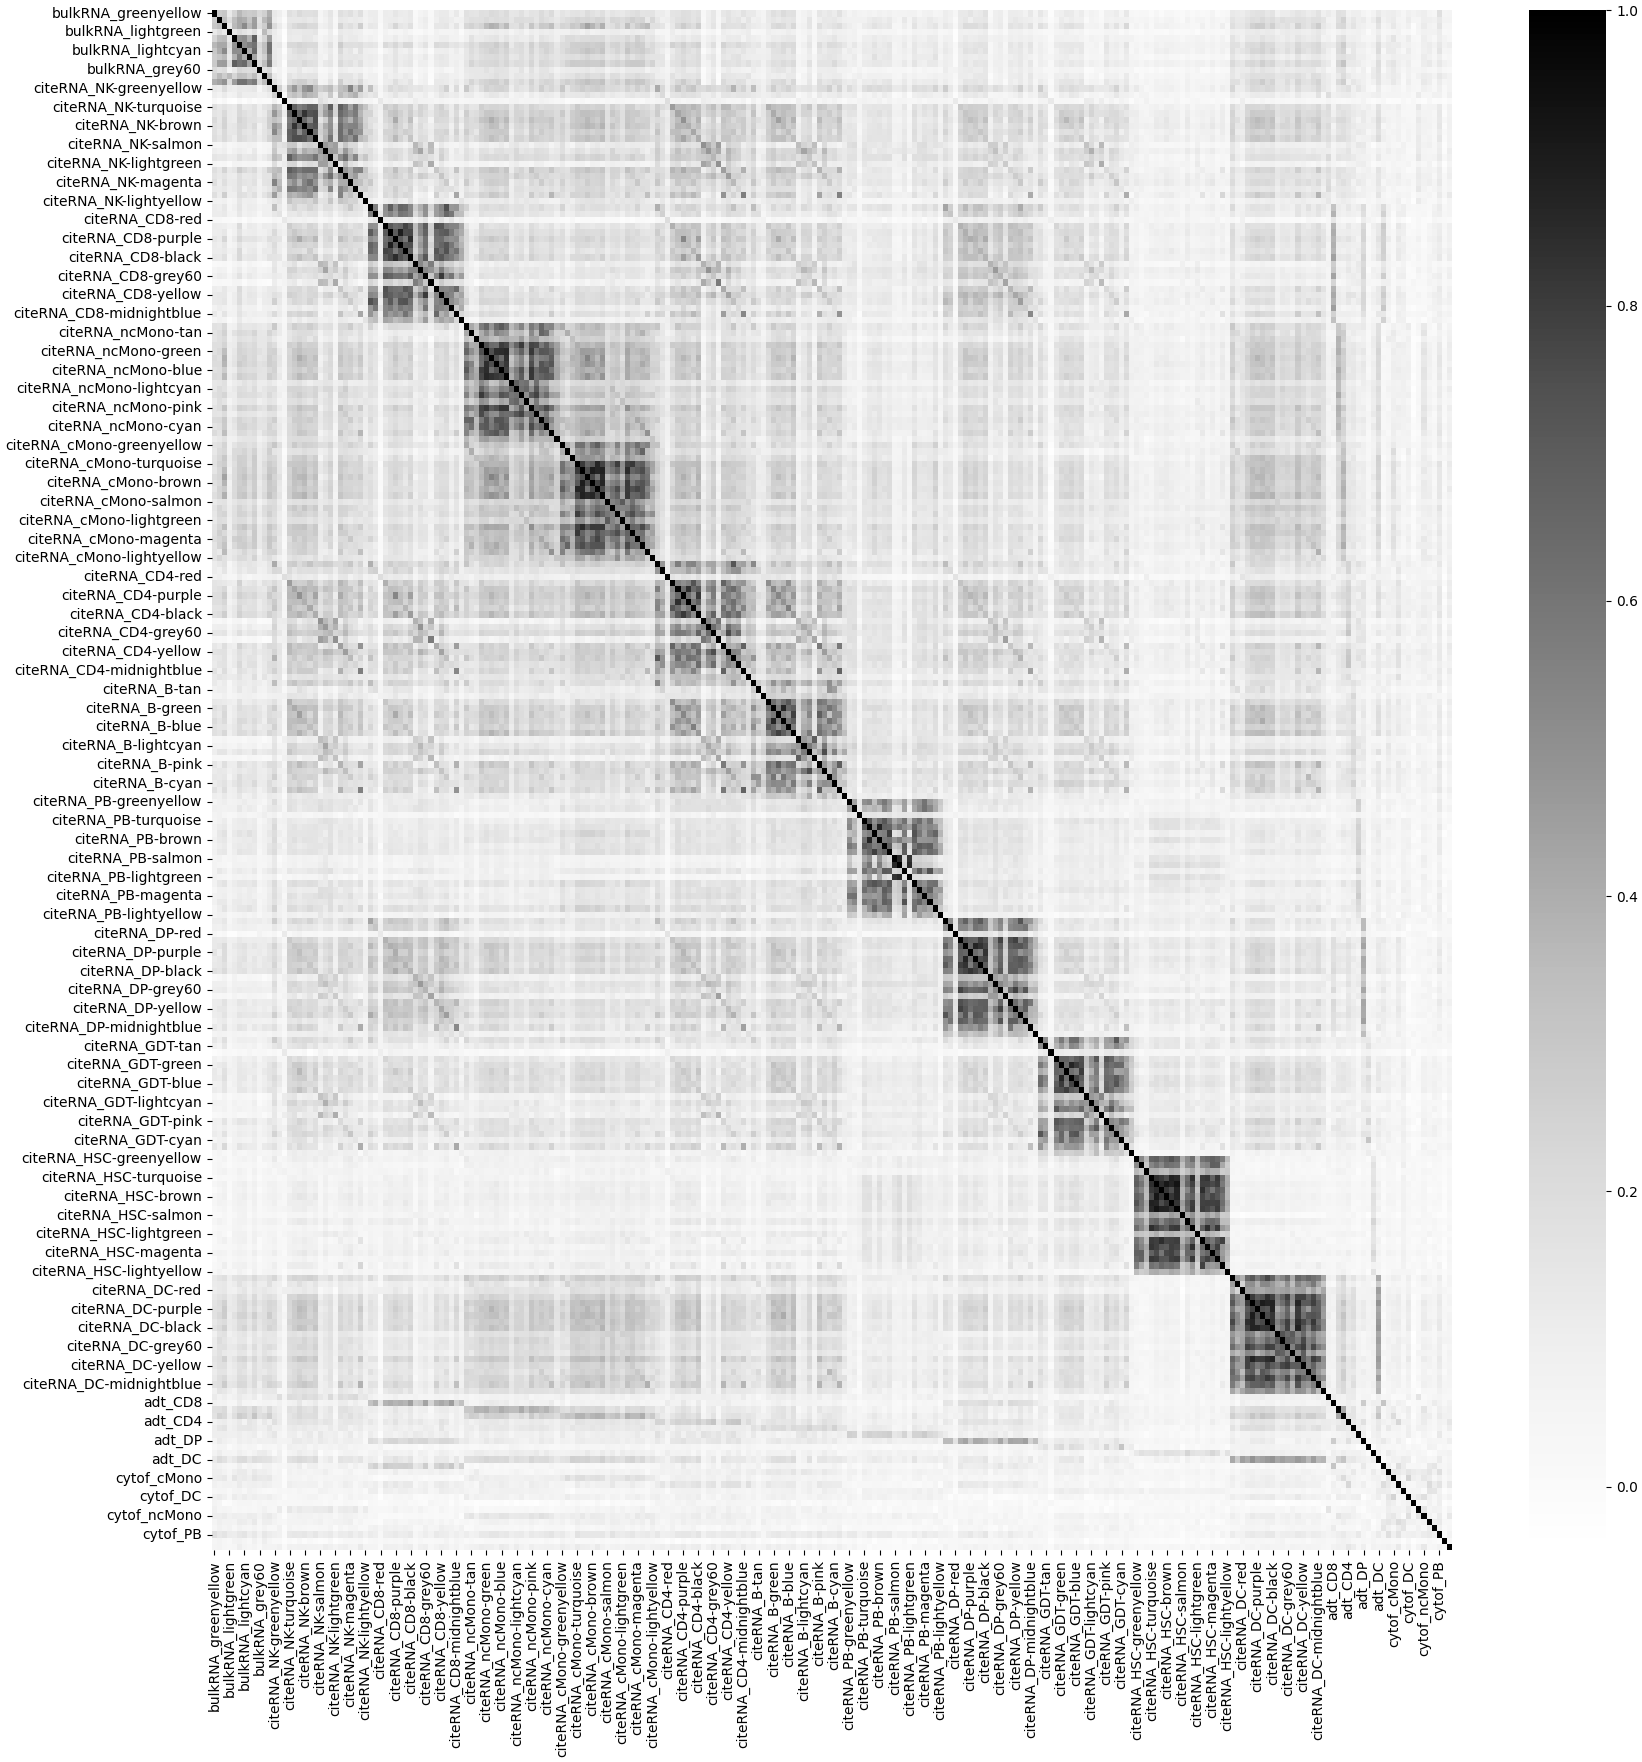

In [63]:
correlation_similarity = []

for g1 in level1_knn_PSNs.values():
    corr_with_g1 = []
    g1 = g1.flatten()
    for g2 in level1_knn_PSNs.values():
        g2 = g2.flatten()
        pearson = np.corrcoef(g1,g2)[0,1]
        corr_with_g1.append(pearson)
    correlation_similarity.append(corr_with_g1)


heat_map_names = [id_to_name[g] for g in level1_knn_PSNs.keys()]
correlation_similarity = np.array(correlation_similarity)
correlation_similarity_with_names = pd.DataFrame(correlation_similarity, index= heat_map_names, columns= heat_map_names)
correlation_similarity = pd.DataFrame(correlation_similarity)
fig, ax = plt.subplots(figsize=(20,20))
sb.heatmap(correlation_similarity_with_names, annot = False, cmap='Greys',ax = ax)

In [64]:
triangle = []
for i in range(len(correlation_similarity_with_names.to_numpy())):
    for j in range(len(correlation_similarity_with_names.to_numpy())):
        if i < j:
            triangle.append(correlation_similarity_with_names.iloc[i,j])

max(triangle)

0.9282279951397102

In [65]:
correlation_similarity.mean().mean()

0.15485829659470315

### Kernel

<Axes: >

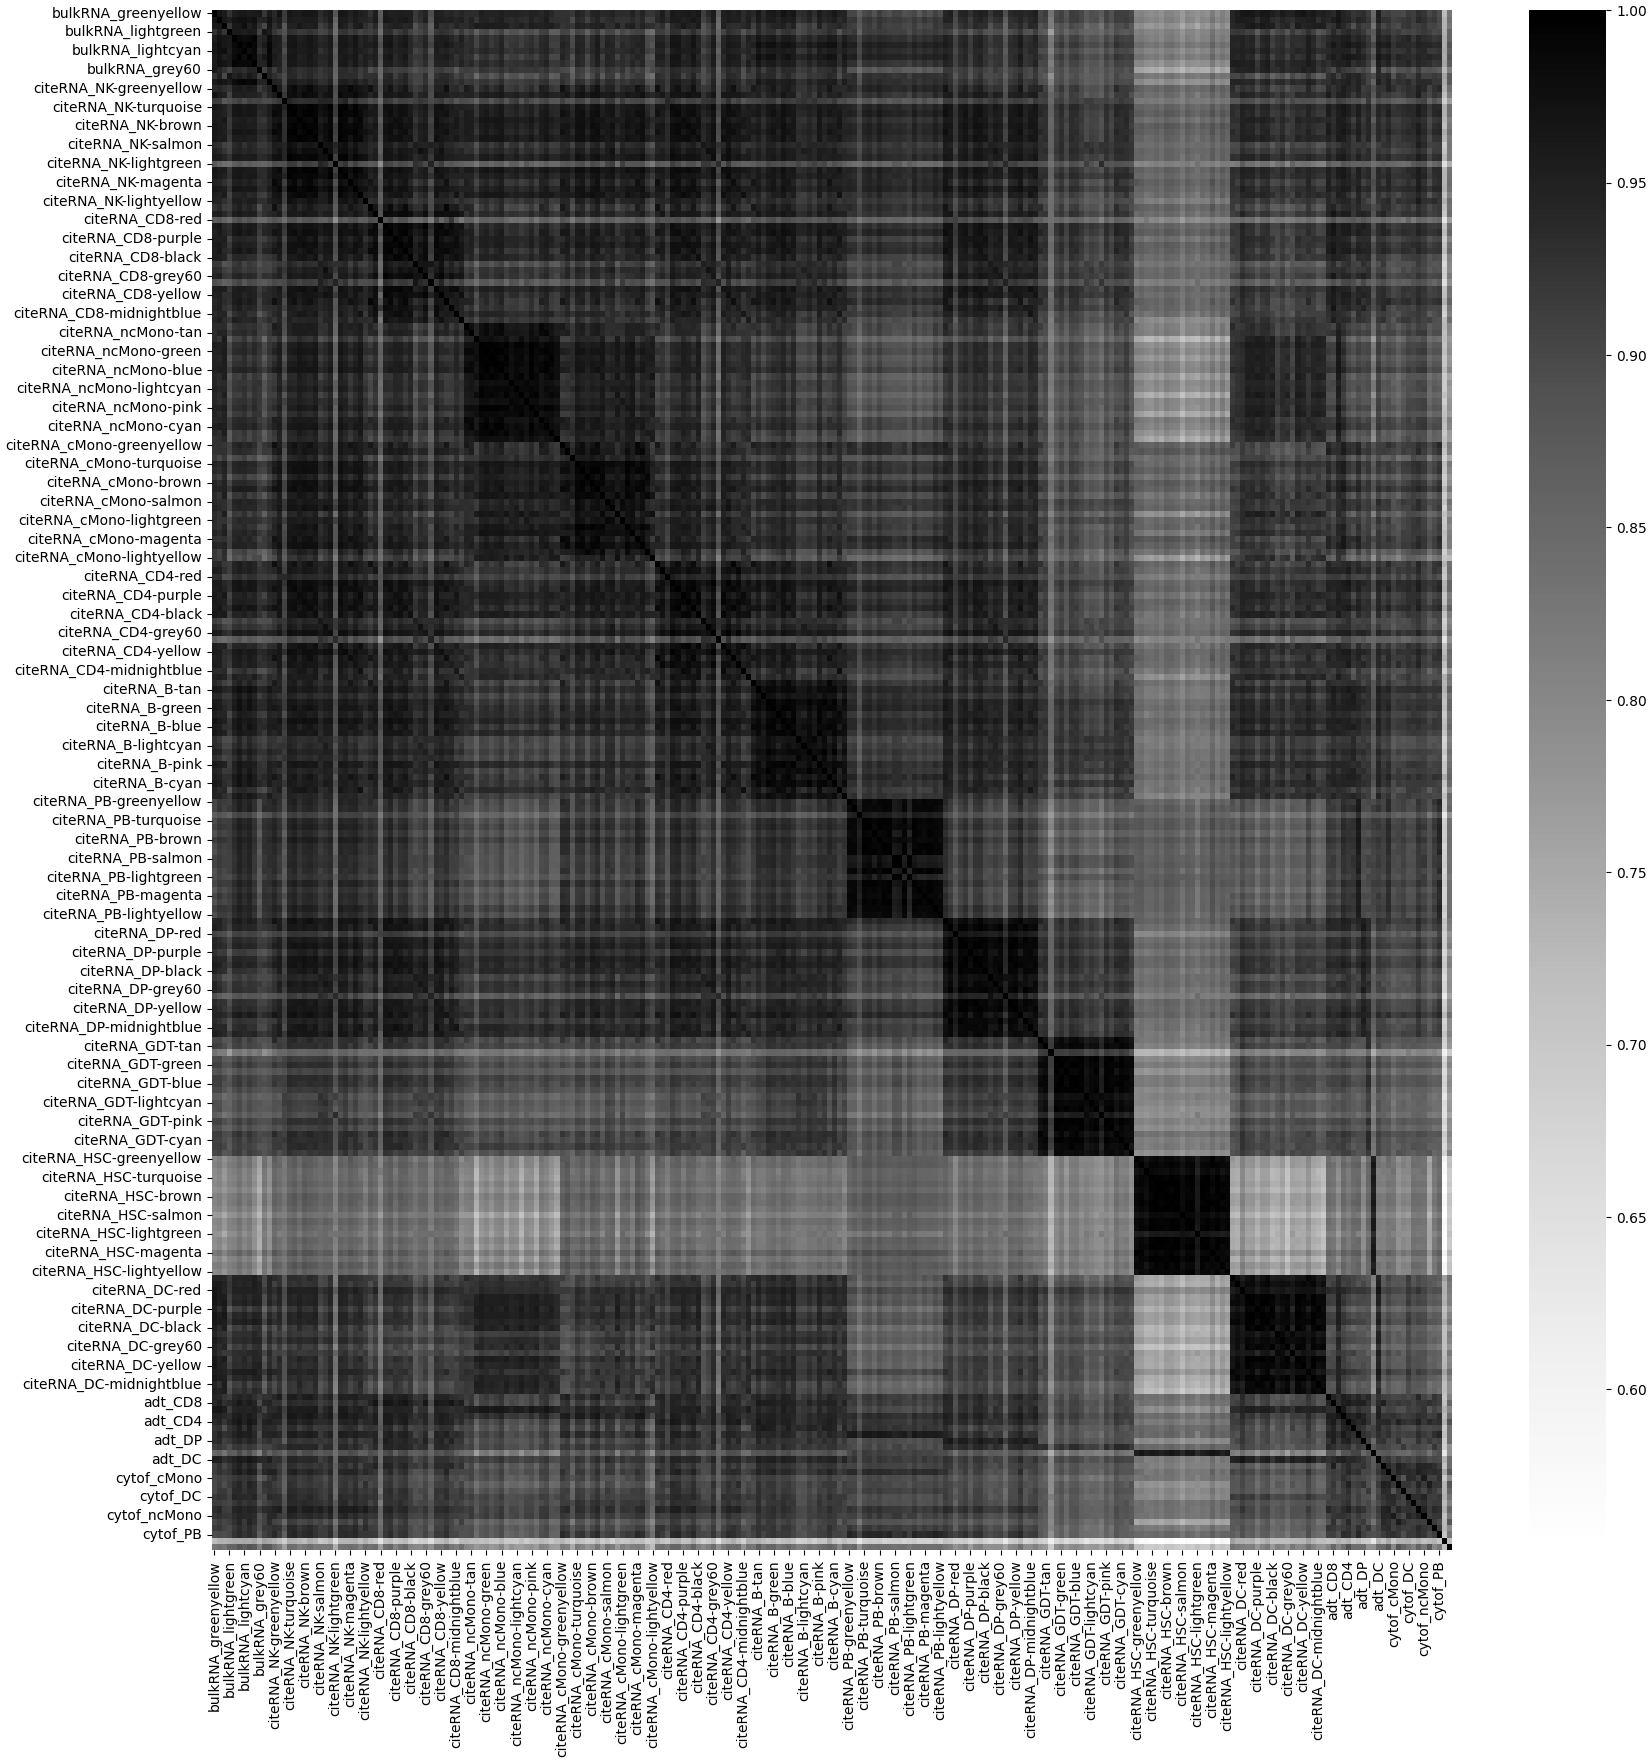

In [66]:
correlation_similarity = []

for g1 in level1_kernel_PSNs.values():
    corr_with_g1 = []
    g1 = g1.flatten()
    for g2 in level1_kernel_PSNs.values():
        g2 = g2.flatten()
        pearson = np.corrcoef(g1,g2)[0,1]
        corr_with_g1.append(pearson)
    correlation_similarity.append(corr_with_g1)


heat_map_names = [id_to_name[g] for g in level1_kernel_PSNs.keys()]
correlation_similarity = np.array(correlation_similarity)
correlation_similarity_with_names = pd.DataFrame(correlation_similarity, index= heat_map_names, columns= heat_map_names)
correlation_similarity = pd.DataFrame(correlation_similarity)
fig, ax = plt.subplots(figsize=(20,20))
sb.heatmap(correlation_similarity_with_names, annot = False, cmap='Greys', ax = ax)

In [67]:
triangle = []
for i in range(len(correlation_similarity_with_names.to_numpy())):
    for j in range(len(correlation_similarity_with_names.to_numpy())):
        if i < j:
            triangle.append(correlation_similarity_with_names.iloc[i,j])

max(triangle)

0.9992750495235327

In [68]:
correlation_similarity.mean().mean()

0.905489723087636

## Similarity of Modalities in L2

### KNN

<Axes: >

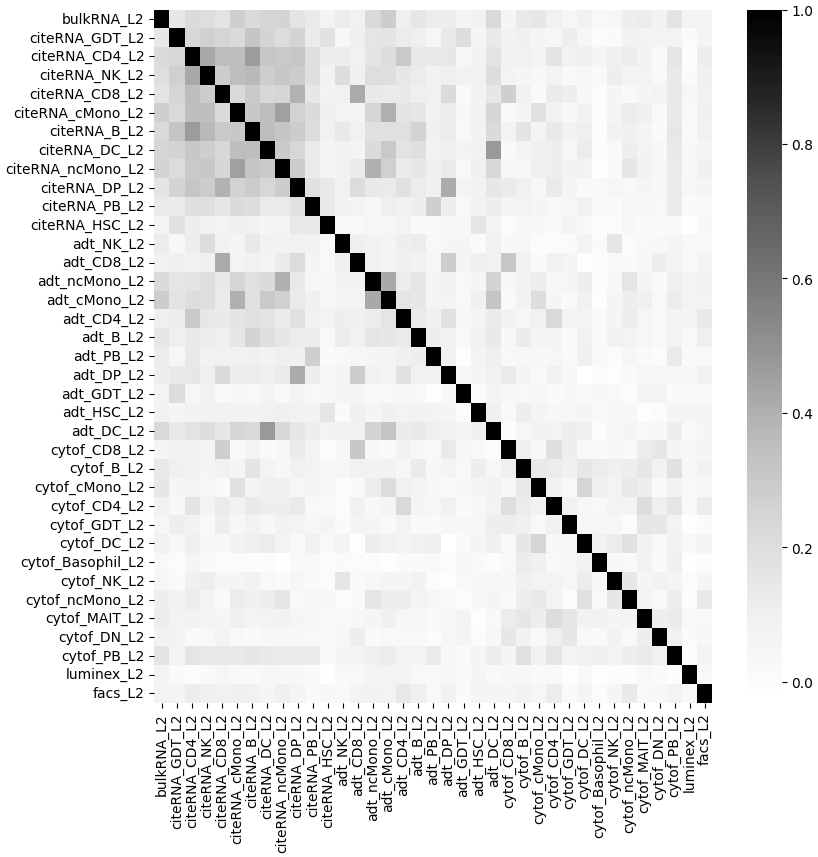

In [69]:
correlation_similarity = []

for g1 in level2_knn_PSNs.values():
    corr_with_g1 = []
    g1 = g1.flatten()
    for g2 in level2_knn_PSNs.values():
        g2 = g2.flatten()
        pearson = np.corrcoef(g1,g2)[0,1]
        corr_with_g1.append(pearson)
    correlation_similarity.append(corr_with_g1)


heat_map_names = [id_to_name[g] for g in level2_knn_PSNs.keys()]
correlation_similarity = np.array(correlation_similarity)
correlation_similarity_with_names = pd.DataFrame(correlation_similarity, index= heat_map_names, columns= heat_map_names)
correlation_similarity = pd.DataFrame(correlation_similarity)
fig, ax = plt.subplots(figsize=(9,9))
sb.heatmap(correlation_similarity_with_names, annot = False, cmap='Greys', ax = ax)

In [70]:
triangle = []
for i in range(len(correlation_similarity_with_names.to_numpy())):
    for j in range(len(correlation_similarity_with_names.to_numpy())):
        if i < j:
            triangle.append(correlation_similarity_with_names.iloc[i,j])

max(triangle)

0.47528476417972804

In [71]:
correlation_similarity.mean().mean()

0.12312316391563012

In [72]:
fig.savefig(os.path.join(write_path, "sim_KNN2"))

### Kernel

<Axes: >

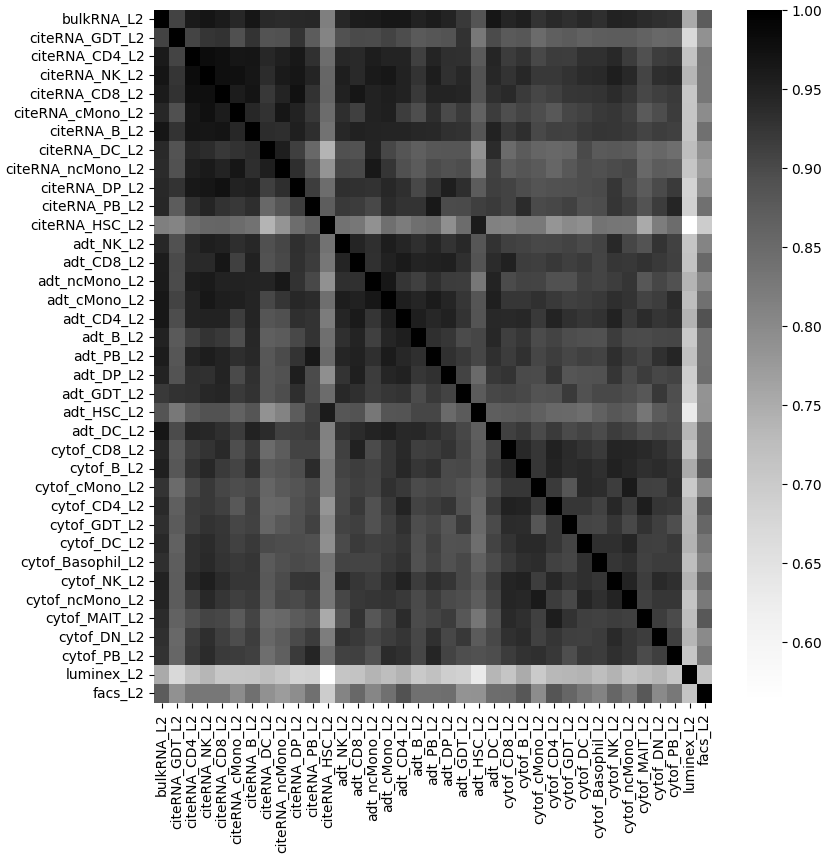

In [73]:
correlation_similarity = []

for g1 in level2_kernel_PSNs.values():
    corr_with_g1 = []
    g1 = g1.flatten()
    for g2 in level2_kernel_PSNs.values():
        g2 = g2.flatten()
        pearson = np.corrcoef(g1,g2)[0,1]
        corr_with_g1.append(pearson)
    correlation_similarity.append(corr_with_g1)


heat_map_names = [id_to_name[g] for g in level2_kernel_PSNs.keys()]
correlation_similarity = np.array(correlation_similarity)
correlation_similarity_with_names = pd.DataFrame(correlation_similarity, index= heat_map_names, columns= heat_map_names)
correlation_similarity = pd.DataFrame(correlation_similarity)
fig, ax = plt.subplots(figsize=(9,9))
sb.heatmap(correlation_similarity_with_names, annot = False, cmap='Greys',ax= ax)

In [74]:
triangle = []
for i in range(len(correlation_similarity_with_names.to_numpy())):
    for j in range(len(correlation_similarity_with_names.to_numpy())):
        if i < j:
            triangle.append(correlation_similarity_with_names.iloc[i,j])

max(triangle)

0.9818010555263101

In [75]:
correlation_similarity.mean().mean()

0.8994030270879816

In [76]:
fig.savefig(os.path.join(write_path, "sim_Kernel2"))

## Similarity of Modalities in L3

### KNN

<Axes: >

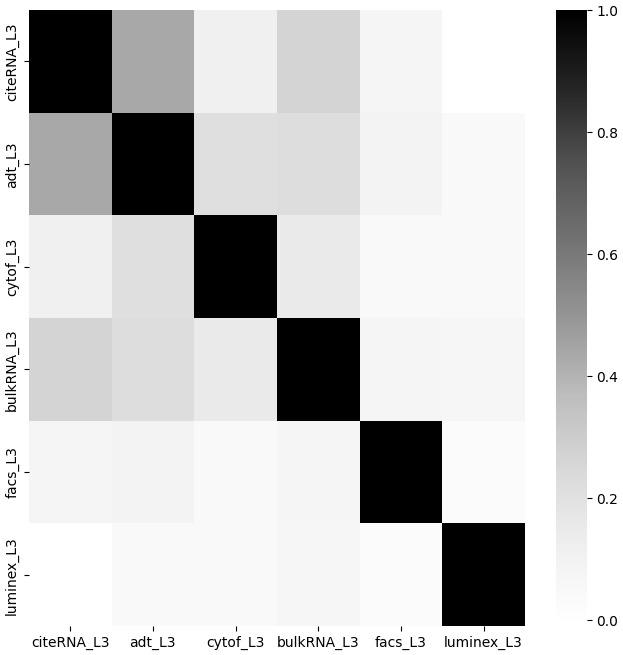

In [77]:
correlation_similarity = []

for g1 in level3_knn_PSNs.values():
    corr_with_g1 = []
    g1 = g1.flatten()
    for g2 in level3_knn_PSNs.values():
        g2 = g2.flatten()
        pearson = np.corrcoef(g1,g2)[0,1]
        corr_with_g1.append(pearson)
    correlation_similarity.append(corr_with_g1)


heat_map_names = [id_to_name[g] for g in level3_knn_PSNs.keys()]
correlation_similarity = np.array(correlation_similarity)
correlation_similarity_with_names = pd.DataFrame(correlation_similarity, index= heat_map_names, columns= heat_map_names)
correlation_similarity = pd.DataFrame(correlation_similarity)
fig, ax = plt.subplots(figsize=(8,8))
sb.heatmap(correlation_similarity_with_names, annot = False, cmap='Greys',ax=ax)

In [78]:
triangle = []
for i in range(len(correlation_similarity_with_names.to_numpy())):
    for j in range(len(correlation_similarity_with_names.to_numpy())):
        if i < j:
            triangle.append(correlation_similarity_with_names.iloc[i,j])

max(triangle)

0.4387581966445324

In [79]:
correlation_similarity.mean().mean()

0.27006081232461265

In [80]:
fig.savefig(os.path.join(write_path, "sim_KNN3"))

### Kernel

<Axes: >

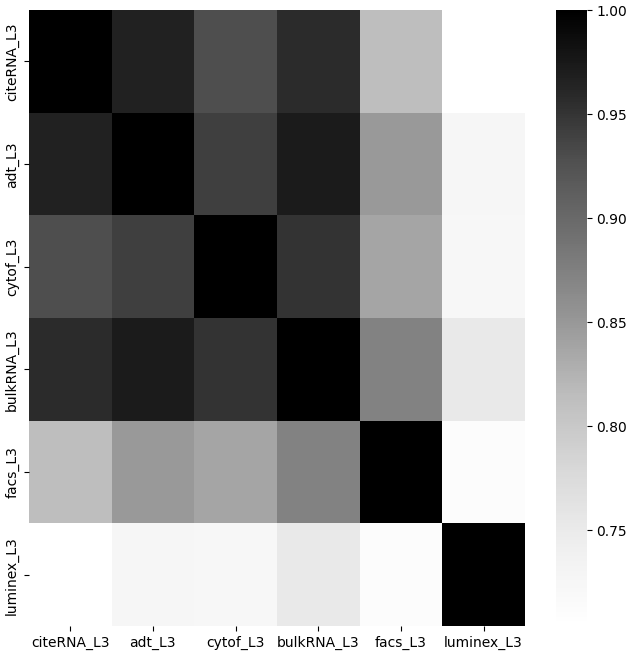

In [81]:
correlation_similarity = []

for g1 in level3_kernel_PSNs.values():
    corr_with_g1 = []
    g1 = g1.flatten()
    for g2 in level3_kernel_PSNs.values():
        g2 = g2.flatten()
        pearson = np.corrcoef(g1,g2)[0,1]
        corr_with_g1.append(pearson)
    correlation_similarity.append(corr_with_g1)


heat_map_names = [id_to_name[g] for g in level3_kernel_PSNs.keys()]
correlation_similarity = np.array(correlation_similarity)
correlation_similarity_with_names = pd.DataFrame(correlation_similarity, index= heat_map_names, columns= heat_map_names)
correlation_similarity = pd.DataFrame(correlation_similarity)
fig, ax = plt.subplots(figsize=(8,8))
sb.heatmap(correlation_similarity_with_names, annot = False, cmap='Greys',  ax=ax)

In [82]:
triangle = []
for i in range(len(correlation_similarity_with_names.to_numpy())):
    for j in range(len(correlation_similarity_with_names.to_numpy())):
        if i < j:
            triangle.append(correlation_similarity_with_names.iloc[i,j])

max(triangle)

0.9731629574290356

In [83]:
correlation_similarity.mean().mean()

0.8730408546699082

In [84]:
fig.savefig(os.path.join(write_path, "sim_Kernel3"))

##  SNF Score Decline with Noise

In [85]:
# Method 1
non_noise_fused = level1_fusions["snf_kernel"]
non_noise_c = level1_cluster_info["fused_kernels"]

all_fused = compute.snf(level1_all["kernel_psns"], K=7, t = 40) 
first, second = compute.get_n_clusters(all_fused)
all_c = cluster.spectral_clustering(all_fused, n_clusters=first, n_init = 40)

In [86]:
all_s_score = skl.metrics.silhouette_score(all_fused, all_c)
all_db_score = skl.metrics.davies_bouldin_score(all_fused, all_c)
transition = make_transition_matrix(all_fused)
all_pr_score = random_walker_objective(transition)[2]
all_acc = labels(all_c)
#all_ami_score = ami(list(gt_d.values()), all_c)
all_ami_score = metrics.nmi([list(gt_d.values()), all_c])[0,1]

non_noise_s_score = skl.metrics.silhouette_score(non_noise_fused, non_noise_c)
non_noise_db_score = skl.metrics.davies_bouldin_score(non_noise_fused, non_noise_c)
transition = make_transition_matrix(non_noise_fused)
non_noise_pr_score = random_walker_objective(transition)[2]
none_noise_acc = labels(non_noise_c)
#non_noise_ami_score = ami(list(gt_d.values()), non_noise_c)
non_noise_ami_score = metrics.nmi([list(gt_d.values()), non_noise_c])[0,1]

In [87]:
print(all_acc <  none_noise_acc, all_ami_score < non_noise_ami_score)

False False True True True


## WA Score Decline with Noise

In [88]:
# Method 2
non_noise_fused = level1_fusions["wa_knn_frequency"]
non_noise_c = level1_cluster_info["fused_knn_frequency"]

all_fused = 0
for i, name in enumerate(level1_all["names"]):
    all_fused = weights[name] * level1_all["knn_psns"][i]

ad_obj = ad.AnnData(all_fused)
ad_obj.obsp["connectivities"] = all_fused
scp.tl.leiden(ad_obj, resolution=0.8, adjacency=all_fused, directed=False, use_weights=True)
all_c = list(ad_obj.obs.leiden)

In [89]:
#non_noise_ami_score = ami(list(gt_d.values()), non_noise_c)
non_noise_ami_score = metrics.nmi([list(gt_d.values()), non_noise_c])[0,1]

non_noise_acc = labels(non_noise_c)
transition = make_transition_matrix(non_noise_fused)
non_noise_pr_score = random_walker_objective(transition)[2]


#all_ami_score = ami(list(gt_d.values()), all_c)
all_ami_score = metrics.nmi([list(gt_d.values()), all_c])[0,1]

all_acc = labels(all_c)
transition = make_transition_matrix(all_fused)
all_pr_score = random_walker_objective(transition)[2]

In [90]:
len(set(all_c)) ==  len(set(non_noise_c))

False

In [91]:
print(all_acc <=  non_noise_acc, all_ami_score < non_noise_ami_score)

False True True


# Positive Control

## Similar contributions

In [92]:
kernel_labels = {"fused": level1_predictions["snf_kernel"]["d"]}
for id, matrix in level1_kernel_PSNs.items():
     kernel_labels = kernel_labels | {id: cluster.spectral_clustering(matrix, n_clusters=first)}


nmi = metrics.nmi(list(kernel_labels.values()))
contributions = nmi[0][1:]

In [93]:
## Kernel-PSN contributin to SNF-Fusion measured via NMI, Similarity measured via NMI, Labels extracted via Spectral Clustering

contributions = np.array(contributions)

similarities = []

similarities = nmi[1:, 1:]
similarities = pd.DataFrame(similarities, index= list(level1_kernel_PSNs.keys()), columns= list(level1_kernel_PSNs.keys()))

contribution_differences = []
for i, c1 in enumerate(contributions):
    cont_diff = []
    for j, c2 in enumerate(contributions):
       cont_diff.append(abs(c1 - c2))
    contribution_differences.append(cont_diff)
contribution_differences = pd.DataFrame(contribution_differences, columns = list(level1_kernel_PSNs.keys()), index = list(level1_kernel_PSNs.keys()))

tolerance = np.percentile(contribution_differences, 35)

pc1 = []
for i in similarities.index:
    pc = []
    for j in similarities.columns:
        s = similarities.loc[i,j]
        c = contribution_differences.loc[i,j]
        if s >= 0.6:
            if c <= tolerance:
                pc.append(1)
            else:
                pc.append(0)
        else:
            pc.append(0.5)
    pc1.append(pc)

<Axes: >

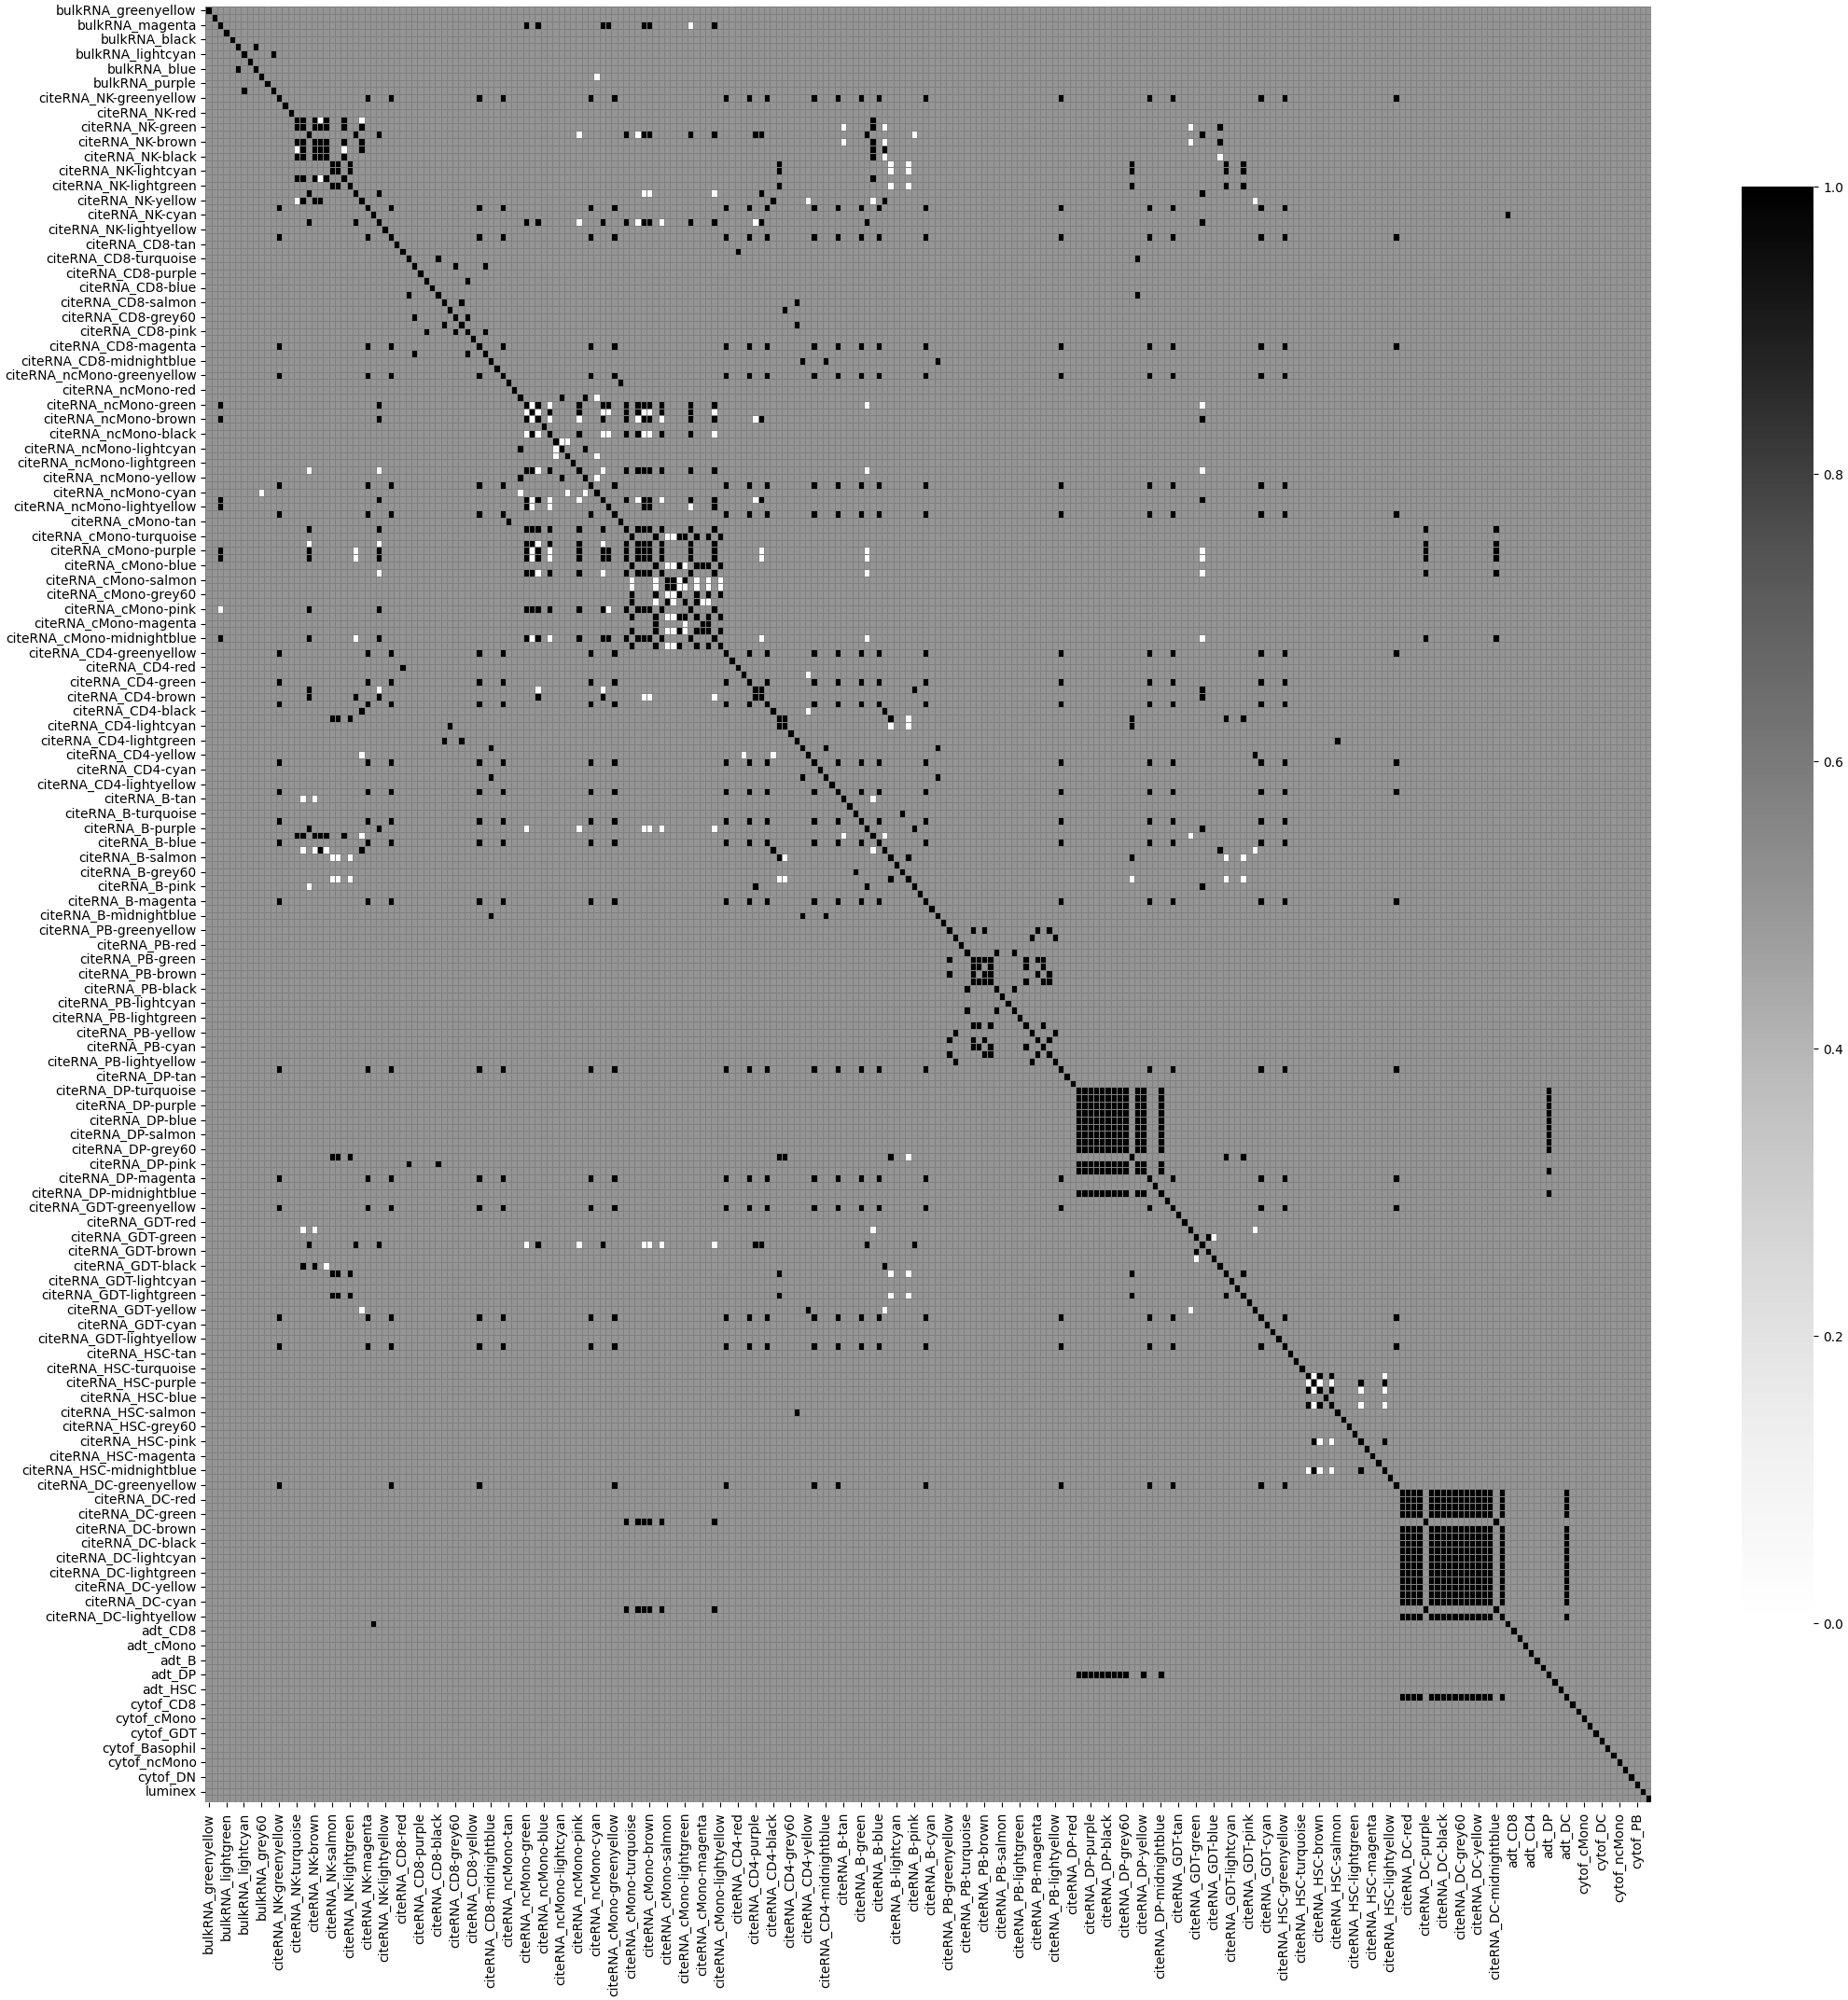

In [94]:
fig, ax = plt.subplots(figsize=(25,25))
names = [id_to_name[id] for id in level1_kernel_PSNs.keys()]
sb.heatmap(pd.DataFrame(pc1, index = names, columns = names), ax = ax, cmap = "Greys", robust = False, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.8}, cbar = True)

In [95]:
fig.savefig(os.path.join(write_path, "pc_Kernel"))

In [96]:
knn_labels = {"fused": level1_predictions["frequency_wa_knn"]["d"]}
for id, matrix in level1_knn_PSNs.items():
    ad_obj =ad.AnnData(matrix)
    ad_obj.obsp["connectivities"] = matrix
    scp.tl.leiden(ad_obj, resolution=1, adjacency=matrix, directed=False, use_weights=True)
    l = list(ad_obj.obs.leiden)
    kernel_labels = kernel_labels | {id: l}


nmi = metrics.nmi(list(kernel_labels.values()))
contributions = nmi[0][1:]

In [97]:

contributions = np.array(contributions)


similarities = nmi[1:, 1:]

similarities = pd.DataFrame(similarities, index= list(level1_knn_PSNs.keys()), columns= list(level1_knn_PSNs.keys()))

contribution_differences = []
for i, c1 in enumerate(contributions):
    cont_diff = []
    for j, c2 in enumerate(contributions):
       cont_diff.append(abs(c1 - c2))
    contribution_differences.append(cont_diff)

contribution_differences = pd.DataFrame(contribution_differences, columns = list(level1_knn_PSNs.keys()), index = list(level1_knn_PSNs.keys()))

tolerance = np.percentile(contribution_differences, 35)

pc2 = []
for i in similarities.index:
    pc = []
    for j in similarities.columns:
        s = similarities.loc[i,j]
        c = contribution_differences.loc[i,j]
        if s >= 0.6:
            if c <= tolerance:
                pc.append(1)
            else:
                pc.append(0)
        else:
            pc.append(0.5)
    pc2.append(pc)

<Axes: >

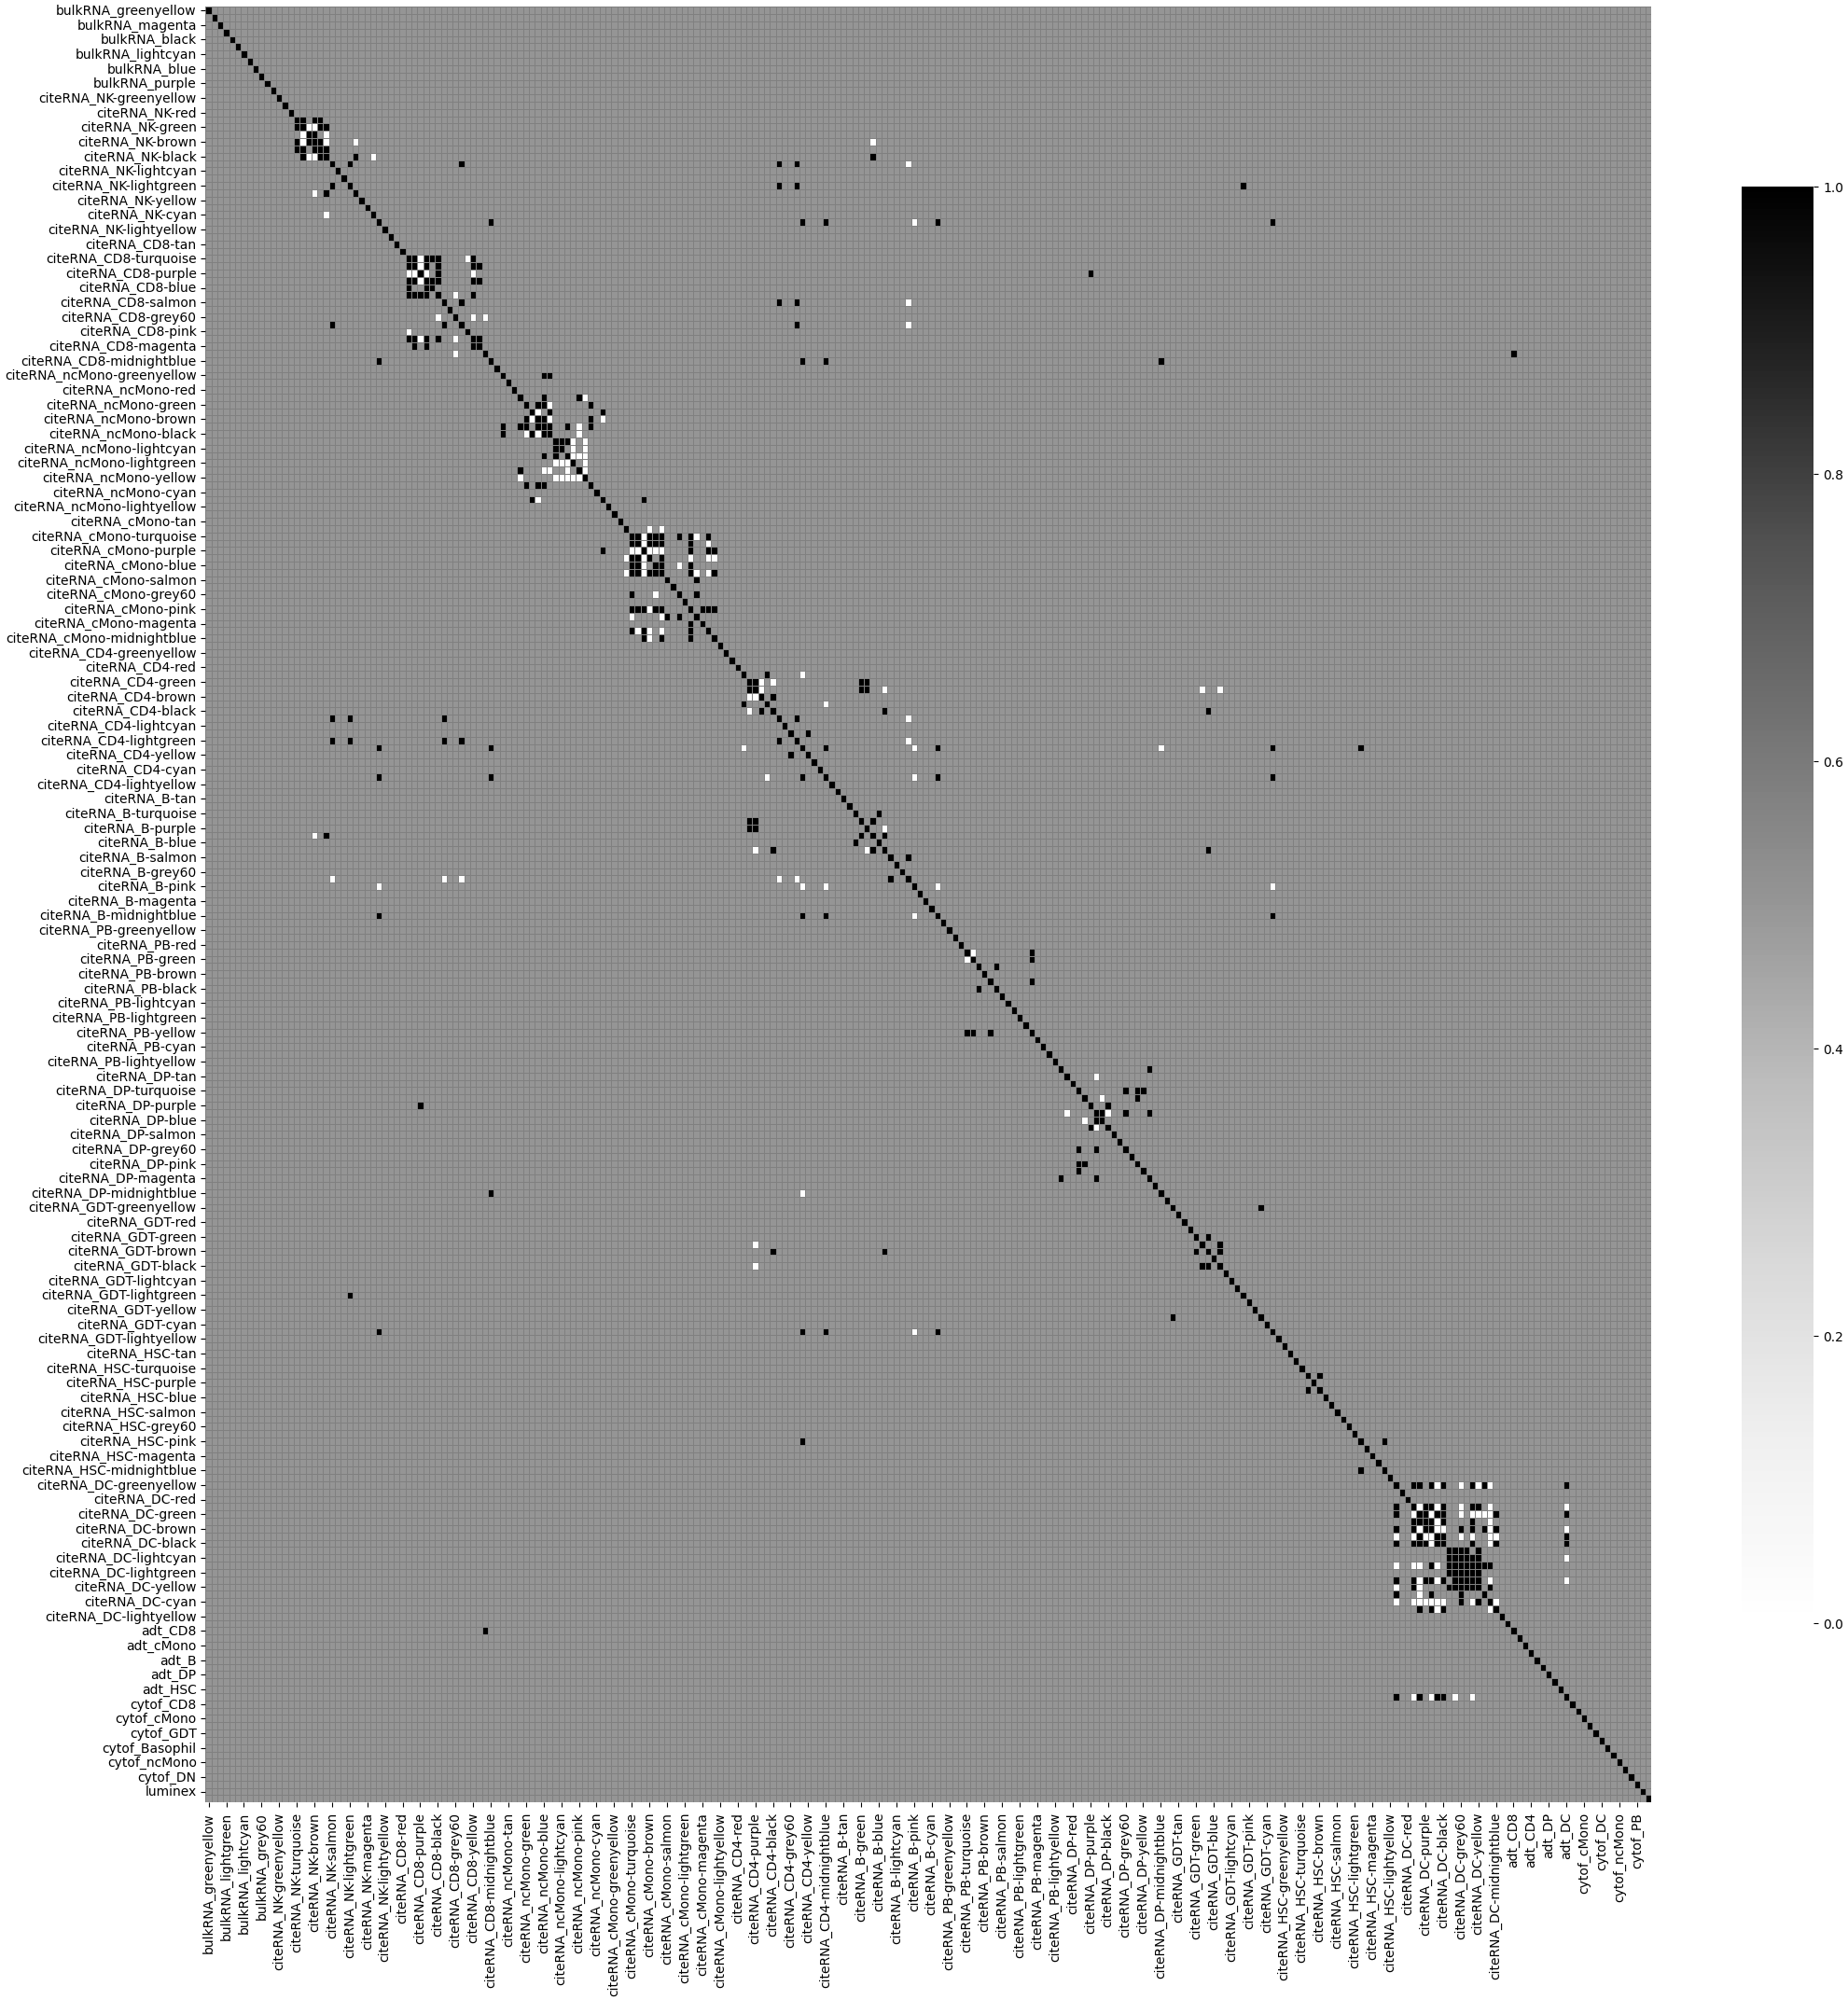

In [98]:
fig, ax = plt.subplots(figsize=(25,25))
names = [id_to_name[id] for id in level1_knn_PSNs.keys()]
sb.heatmap(pd.DataFrame(pc2, index = names, columns = names), ax = ax, cmap = "Greys", robust = False, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.8}, cbar = True)

In [99]:
fig.savefig(os.path.join(write_path, "pc_KNN"))

In [100]:
Counter(np.array(pc1).flatten()) # Number of grey, white and black cells in pc1

Counter({0.5: 58690, 1.0: 1596, 0.0: 230})

In [101]:
Counter(np.array(pc2).flatten()) # Number of grey, white and black cells in pc2

Counter({0.5: 59718, 1.0: 598, 0.0: 200})

## Accuracy improvement

In [102]:
accuracies = 0 
for g in level1_cluster_info["unimodal_kernels"].values():
    _, acc = labels(g, mode = "d")
    accuracies+= acc
    
round(accuracies/len(level1_cluster_info["unimodal_kernels"]),4)

0.0809

In [103]:
round(labels(level1_cluster_info["fused_kernels"], mode = "d")[1],4)

0.3919

In [104]:
accuracies = 0 
for g in level1_cluster_info["unimodal_knn"].values():
    _, acc = labels(g, mode = "d")
    accuracies+= acc
    
round(accuracies/len(level1_cluster_info["unimodal_knn"]),4)

0.2196

In [105]:
round(labels(level1_cluster_info["fused_knn_frequency"], mode = "d")[1],4)

0.3108

In [106]:
g = level1_fusions["snf_kernel"].copy()
g[g<0.005] = 0

# adjacency matrix after filtering
exist = (g != 0) * 1.0
    
factor = np.ones(g.shape[1])
res = np.dot(exist, factor)     #degree of each node
diag_matrix = np.diag(res)  #degree matrix
   
#calculate the laplace matrix
d_inv = np.linalg.inv(diag_matrix)
g_input_to_GCN = d_inv.dot(exist)

first, second = compute.get_n_clusters(g_input_to_GCN)
l = cluster.spectral_clustering(g_input_to_GCN, n_clusters=first, n_init = 40)

round(labels(l, mode = "d")[1],4)

/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


0.4054

# Contributions of Unimodal PSNs to the fusion output

## SNF

### SNF-L1

In [114]:
kernel_labels = {"ground_truth": list(gt_d.values()) , "snf": level1_cluster_info["fused_kernels"]} 
for id, matrix in level1_kernel_PSNs.items():
     kernel_labels = kernel_labels | {id: cluster.spectral_clustering(matrix, n_clusters=first)}


nmi = metrics.nmi(list(kernel_labels.values()))
ami_kernel = nmi[:2, 2:]

In [116]:
contribution_differences = []
df = pd.DataFrame(ami_kernel, index = ["gt", "snf"], columns = list(level1_graphs.keys()))

for col in df.columns:
    gt_cont = df.loc["gt", col]
    snf_cont = df.loc["snf", col]
    contribution_differences.append(abs(gt_cont - snf_cont))

tolerance = np.percentile(contribution_differences, 35)
contribution = []


for col in df.columns:
    gt_cont = df.loc["gt", col]
    snf_cont = df.loc["snf", col]
    if abs(gt_cont - snf_cont) <= tolerance:
        contribution.append("equal")
    elif gt_cont > snf_cont:
        contribution.append("low")
    elif gt_cont < snf_cont:
        contribution.append("high")

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Incresing ncol
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


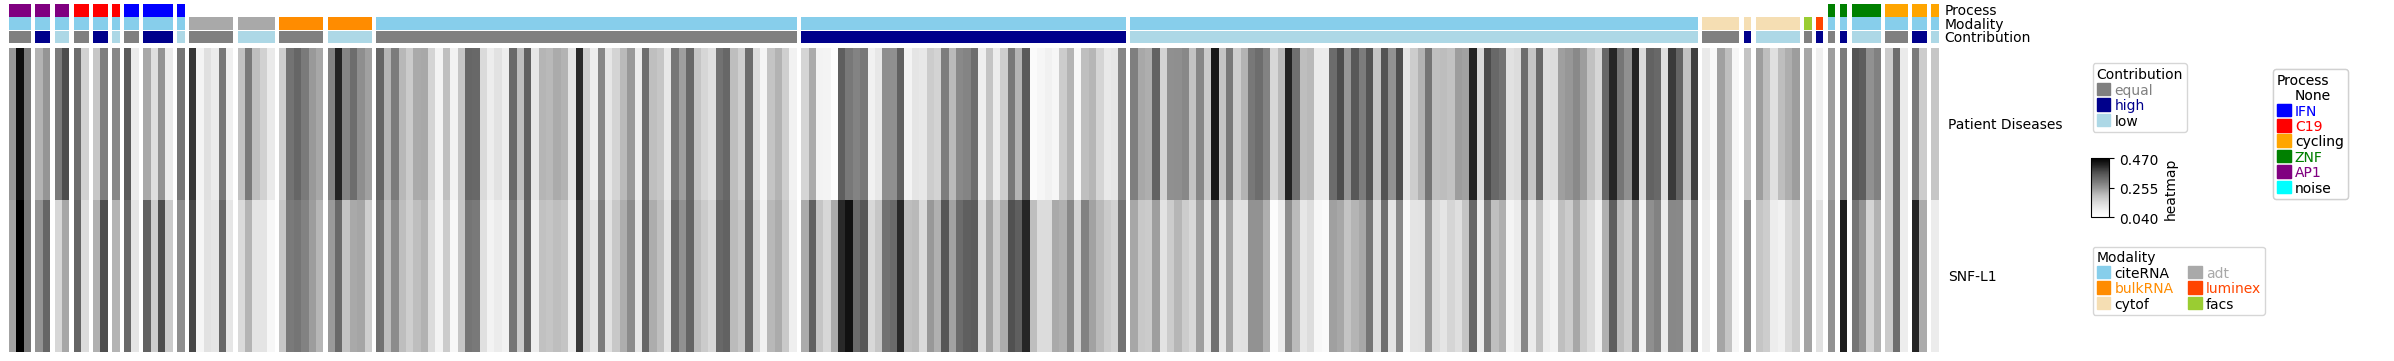

In [117]:
number_to_modality = {}
number_to_contribution = {}
number_to_process = {}


for i, id in enumerate(level1_graphs.keys()):

    number_to_modality[i] = level1_graphs[id].uns["modality"]
    number_to_contribution[i] = contribution[i]
    number_to_process[i] = level1_graphs[id].uns["module"]


df_column = pd.DataFrame(number_to_modality.values(), columns=["modality"] ).join(pd.DataFrame(number_to_contribution.values(), columns=["contribution"])).join(pd.DataFrame(number_to_process.values(), columns=["process"]))


col_colors_dict = {"process":{"None": "white", "IFN": "blue", "C19": "red", "cycling": "orange", "ZNF": "green", "AP1": "purple", "noise": "cyan" },
                  "modality":{"citeRNA":"skyblue", "bulkRNA": "darkorange" , "cytof": "wheat", "adt": "darkgray", "luminex": "orangered", "facs": "yellowgreen"},
                  "contribution":{"equal": "grey", "high": "darkblue", "low":"lightblue"}  }


col_ha= HeatmapAnnotation(Process=anno_simple(df_column.process,colors=col_colors_dict['process'],rasterized=True),
                          Modality=anno_simple(df_column.modality,colors=col_colors_dict['modality'],rasterized=True),
                          Contribution=anno_simple(df_column.contribution,colors=col_colors_dict['contribution'],rasterized=True),
                          axis=1)


fig, ax = plt.subplots(figsize=(25,4))
df = pd.DataFrame(ami_kernel, index = ["Patient Diseases", "SNF-L1"],  columns = list(number_to_modality.keys())) # Data Frame containing normalized data for each score
ami_kernel_plt = ClusterMapPlotter(df, top_annotation=col_ha,
                     show_rownames=True,show_colnames=False,
                     row_dendrogram=False,col_dendrogram=False,
                     col_split=df_column.loc[:, ['process', 'modality', 'contribution']],
                     cmap='Greys',
                     rasterized=True,col_split_gap=1.2,legend=True,legend_anchor='ax_heatmap',legend_vpad=5,legend_hpad= 8, row_split_gap=1.2 )

In [118]:
sum((df.loc["Patient Diseases"]>0.3 ) * 1)

55

In [119]:
fig.savefig(os.path.join(write_path, "SNF1-cont"))

In [120]:
module_analysis = {}
for mod_name, graphs in module_info.items():
    for g in graphs:
        loc = int(g.split("G")[1])
        name = id_to_name[g].split("_")[1]
        module_analysis[mod_name + "_" + name ] = ami_kernel[1][loc]
        
module_analysis = {k: v for k, v in sorted(module_analysis.items(), key=lambda item: item[1])} 
for i in range(30):
    print(list(module_analysis.keys())[-i-1])

print("***************************")

contribution_map = {}
for idx, val in enumerate(ami_kernel[1]):
    contribution_map[list(level1_graphs.keys())[idx]]= val

contribution_map = {k: v for k, v in sorted(contribution_map.items(), key=lambda item: item[1])} 


high_contributors = []
var_names = {}
for i in range(20):
    id = list(contribution_map.keys())[-i-1]
    name = id_to_name[id]
    print(name)
    high_contributors.append(name)
    modality = name.split("_")[0]
    if modality not in var_names.keys():
        var_names[modality] = []
    var_names[modality] += list(level1_graphs[id].var_names)

AP1_cMono-lightcyan
ZNF_cMono-turquoise
cycling_cMono-grey60
C19_cMono-green
IFN_cMono-black
IFN_ncMono-green
C19_ncMono-brown
AP1_ncMono-magenta
IFN_NK-purple
cycling_NK-blue
ZNF_NK-turquoise
AP1_CD4-green
IFN_PB-brown
IFN_B-purple
ZNF_CD4-turquoise
ZNF_ncMono-purple
AP1_ncMono-greenyellow
AP1_NK-brown
AP1_B-blue
cycling_B-cyan
cycling_PB-turquoise
C19_NK-greenyellow
ZNF_B-turquoise
C19_B-magenta
cycling_CD4-black
IFN_CD4-pink
ZNF_CD8-yellow
AP1_CD8-black
C19_CD4-midnightblue
IFN_CD8-midnightblue
***************************
citeRNA_cMono-lightcyan
citeRNA_cMono-blue
citeRNA_cMono-turquoise
citeRNA_cMono-grey60
citeRNA_ncMono-red
citeRNA_cMono-yellow
citeRNA_cMono-cyan
citeRNA_CD4-yellow
adt_cMono
citeRNA_cMono-green
citeRNA_cMono-black
citeRNA_cMono-salmon
citeRNA_ncMono-lightgreen
citeRNA_cMono-pink
citeRNA_CD4-brown
citeRNA_cMono-brown
citeRNA_ncMono-lightyellow
citeRNA_GDT-blue
citeRNA_B-greenyellow
citeRNA_ncMono-green


In [121]:
with open(os.path.join(write_path, 'snf1_names.pickle'), 'wb') as f:
    pickle.dump(high_contributors, f)

with open(os.path.join(write_path, 'snf1_modules.pickle'), 'wb') as f:
    pickle.dump(module_analysis, f)

### SNF-L2

In [127]:
kernel_labels = {"ground_truth": list(gt_d.values()) , "snf": level2_cluster_info["fused_kernels"]} 
for id, matrix in level2_kernel_PSNs.items():
     kernel_labels = kernel_labels | {id: cluster.spectral_clustering(matrix, n_clusters=first)}


nmi = metrics.nmi(list(kernel_labels.values()))
ami_kernel = nmi[:2, 2:]

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..


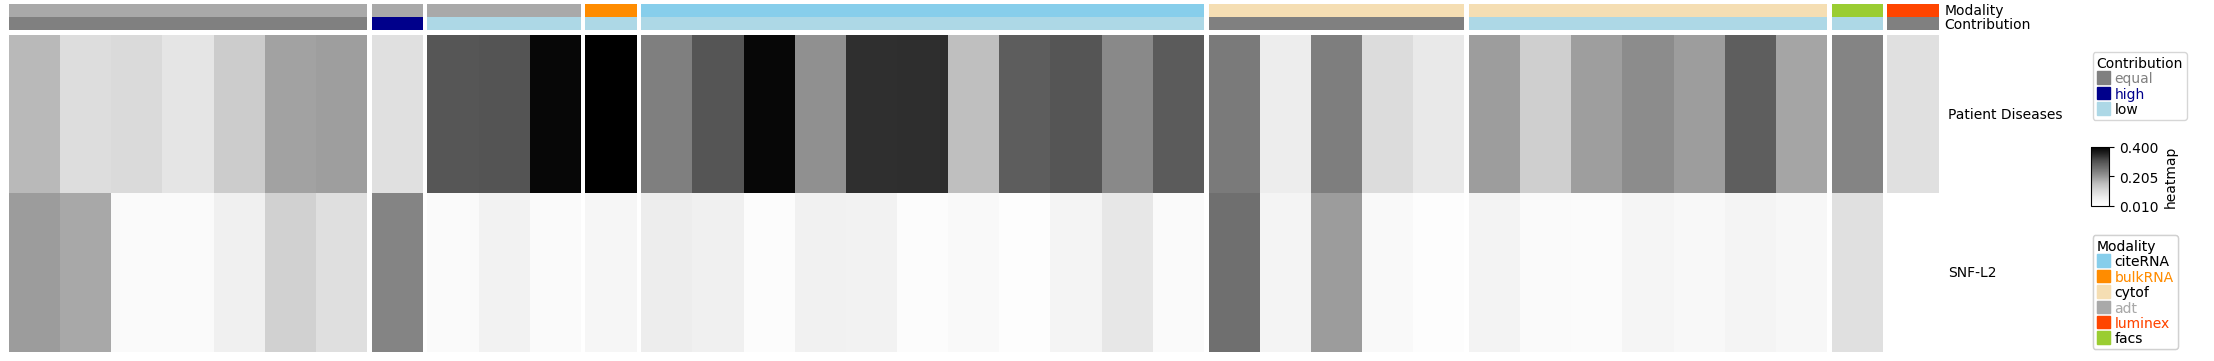

In [129]:
contribution_differences = []
df = pd.DataFrame(ami_kernel, index = ["gt", "snf"], columns = list(level2_kernel_PSNs.keys()))

for col in df.columns:
    gt_cont = df.loc["gt", col]
    snf_cont = df.loc["snf", col]
    contribution_differences.append(abs(gt_cont - snf_cont))

tolerance = np.percentile(contribution_differences, 35)
contribution = []


for col in df.columns:
    gt_cont = df.loc["gt", col]
    snf_cont = df.loc["snf", col]
    if abs(gt_cont - snf_cont) <= tolerance:
        contribution.append("equal")
    elif gt_cont > snf_cont:
        contribution.append("low")
    elif gt_cont < snf_cont:
        contribution.append("high")

number_to_modality = {}
number_to_contribution = {}
number_to_cell_type= {}

for i, id in enumerate(level2_kernel_PSNs.keys()):

    number_to_modality[i] = level2_graphs[id].uns["modality"]
    number_to_contribution[i] = contribution[i]
    number_to_cell_type[i] = level2_graphs[id].uns["cell-type"]


df_column = pd.DataFrame(number_to_modality.values(), columns=["modality"] ).join(pd.DataFrame(number_to_contribution.values(), columns=["contribution"])).join(pd.DataFrame(number_to_cell_type.values(), columns=["cell_type"]))


col_colors_dict = {"modality":{"citeRNA":"skyblue", "bulkRNA": "darkorange" , "cytof": "wheat", "adt": "darkgray", "luminex": "orangered", "facs": "yellowgreen"},
                  "contribution":{"equal": "grey", "high": "darkblue", "low":"lightblue"} }
                   #"cell_type":{"B":"darkblue", "Basophil": "darkred" , "CD4": "darkorange", "CD8": "brown", "DC": "darkgreen", "DN": "navy", "DP":"black", 'GDT':"lime", 'HSC': "olive", 'MAIT': "fuchsia", 'NK': "maroon", 'PB':"coral", 'bulk':"aqua", 'cMono':"teal", 'ncMono':"plum" }  }


col_ha= HeatmapAnnotation(Modality=anno_simple(df_column.modality,colors=col_colors_dict['modality'],rasterized=True),
                          #CellType=anno_simple(df_column.cell_type,colors=col_colors_dict['cell_type'],rasterized=True),
                          Contribution=anno_simple(df_column.contribution,colors=col_colors_dict['contribution'],rasterized=True),
                          axis=1)


fig, ax = plt.subplots(figsize=(25,4))
df = pd.DataFrame(ami_kernel, index = ["Patient Diseases", "SNF-L2"],  columns = list(number_to_modality.keys())) # Data Frame containing normalized data for each score
ami_kernel_plt = ClusterMapPlotter(df, top_annotation=col_ha,
                     show_rownames=True,show_colnames=False,
                     row_dendrogram=False,col_dendrogram=False,
                     col_split=df_column.loc[:, [ 'modality', 'contribution']],
                     cmap='Greys',
                     rasterized=True,col_split_gap=1.2,legend=True,legend_anchor='ax_heatmap',legend_vpad=5,legend_hpad= 8, row_split_gap=1.2 )

In [ ]:
fig.savefig(os.path.join(write_path, "SNF2-cont"))

In [ ]:
sum((df.loc["Patient Diseases"]>0.3 ) * 1)

6

In [ ]:
contribution_map = {}
for idx, val in enumerate(ami_kernel[1]):
    contribution_map[list(level2_graphs.keys())[idx]]= val

contribution_map = {k: v for k, v in sorted(contribution_map.items(), key=lambda item: item[1])} 


high_contributors = []
high_cont_graph_ids_wa = []
for i in range(10):
    id = list(contribution_map.keys())[-i-1]
    high_cont_graph_ids_wa.append(id)
    name = id_to_name[id]
    print(name)
    high_contributors.append(name)
    modality = name.split("_")[0]

cytof_Basophil_L2
cytof_cMono_L2
cytof_ncMono_L2
cytof_MAIT_L2
cytof_CD4_L2
cytof_B_L2
cytof_NK_L2
cytof_DC_L2
cytof_PB_L2
adt_B_L2


In [ ]:
with open(os.path.join(write_path, 'snf2_names.pickle'), 'wb') as f:
    pickle.dump(high_contributors, f)

### SNF-L3

In [ ]:
kernel_labels = {"ground_truth": list(gt_d.values()) , "snf":level3_cluster_info["fused_kernels"]} 
for id, matrix in level3_kernel_PSNs.items():
     kernel_labels = kernel_labels | {id: cluster.spectral_clustering(matrix, n_clusters=first)}


nmi = metrics.nmi(list(kernel_labels.values()))
ami_kernel = nmi[:2, 2:]

In [ ]:
contribution_differences = []
df = pd.DataFrame(ami_kernel, index = ["gt", "snf"], columns = list(level3_kernel_PSNs.keys()))

for col in df.columns:
    gt_cont = df.loc["gt", col]
    snf_cont = df.loc["snf", col]
    contribution_differences.append(abs(gt_cont - snf_cont))

tolerance = np.percentile(contribution_differences, 35)
contribution = []


for col in df.columns:
    gt_cont = df.loc["gt", col]
    snf_cont = df.loc["snf", col]
    if abs(gt_cont - snf_cont) <= tolerance:
        contribution.append("equal")
    elif gt_cont > snf_cont:
        contribution.append("low")
    elif gt_cont < snf_cont:
        contribution.append("high")

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..


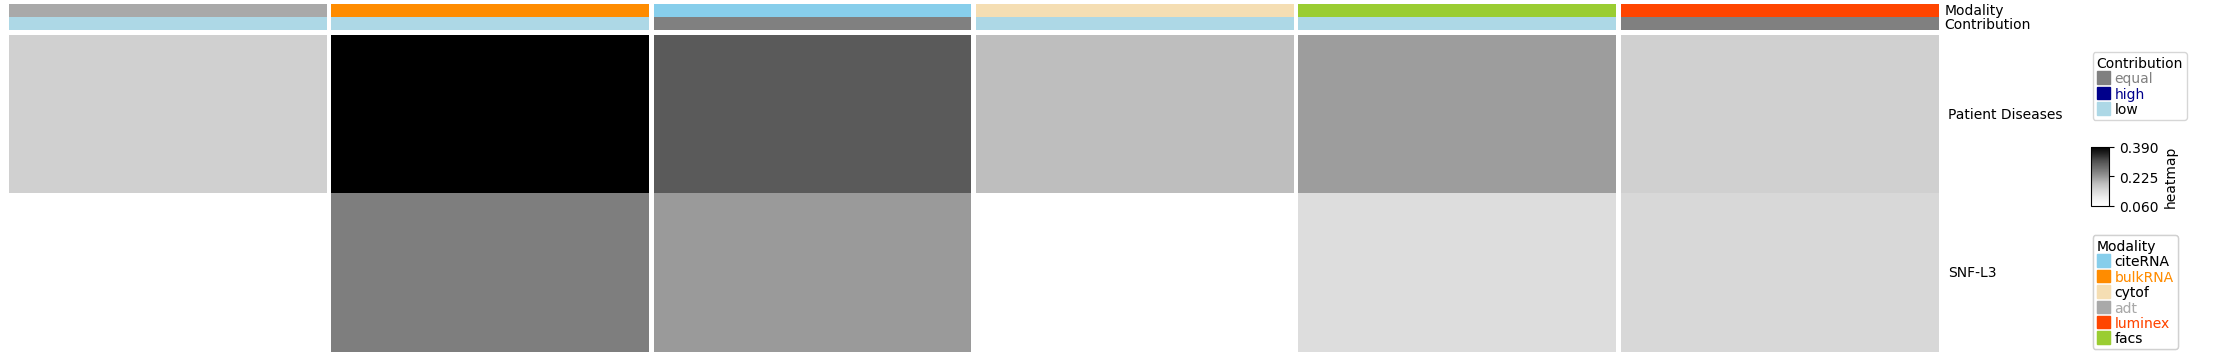

In [ ]:
number_to_modality = {}
number_to_contribution = {}


for i, id in enumerate(level3_kernel_PSNs.keys()):

    number_to_modality[i] = level3_graphs[id].uns["modality"]
    number_to_contribution[i] = contribution[i]


df_column = pd.DataFrame(number_to_modality.values(), columns=["modality"] ).join(pd.DataFrame(number_to_contribution.values(), columns=["contribution"]))


col_colors_dict = {"modality":{"citeRNA":"skyblue", "bulkRNA": "darkorange" , "cytof": "wheat", "adt": "darkgray", "luminex": "orangered", "facs": "yellowgreen"},
                  "contribution":{"equal": "grey", "high": "darkblue", "low":"lightblue"}  }


col_ha= HeatmapAnnotation(Modality=anno_simple(df_column.modality,colors=col_colors_dict['modality'],rasterized=True),
                          Contribution=anno_simple(df_column.contribution,colors=col_colors_dict['contribution'],rasterized=True),
                          axis=1)


fig, ax = plt.subplots(figsize=(25,4))
df = pd.DataFrame(ami_kernel, index = ["Patient Diseases", "SNF-L3"],  columns = list(number_to_modality.keys())) # Data Frame containing normalized data for each score
ami_kernel_plt = ClusterMapPlotter(df, top_annotation=col_ha,
                     show_rownames=True,show_colnames=False,
                     row_dendrogram=False,col_dendrogram=False,
                     col_split=df_column.loc[:, [ 'modality', 'contribution']],
                     cmap='Greys',
                     rasterized=True,col_split_gap=1.2,legend=True,legend_anchor='ax_heatmap',legend_vpad=5,legend_hpad= 8, row_split_gap=1.2 )

In [ ]:
fig.savefig(os.path.join(write_path, "SNF3-cont"))

In [ ]:
sum((df.loc["Patient Diseases"]>0.3 ) * 1)

1

## WA

### WA-L1

In [ ]:
knn_labels = {"ground_truth": list(gt_d.values()) , "wa": level1_cluster_info["fused_knn_frequency"]} 
for id, matrix in level1_knn_PSNs.items():
     knn_labels = knn_labels | {id: cluster.spectral_clustering(matrix, n_clusters=first)}


nmi = metrics.nmi(list(knn_labels.values()))
ami_knn = nmi[:2, 2:]

/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Incresing ncol
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


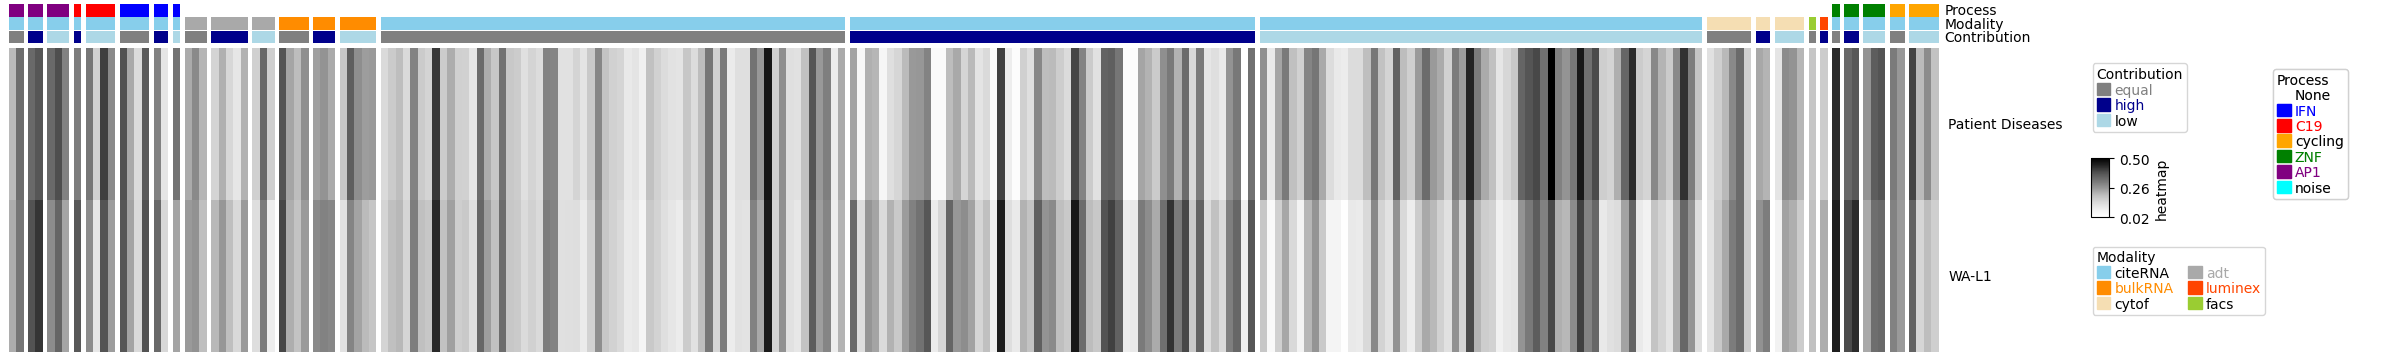

In [ ]:
contribution_differences = []
df = pd.DataFrame(ami_knn, index = ["gt", "wa"], columns = list(level1_knn_PSNs.keys()))

for col in df.columns:
    gt_cont = df.loc["gt", col]
    wa_cont = df.loc["wa", col]
    contribution_differences.append(abs(gt_cont - wa_cont))

tolerance = np.percentile(contribution_differences, 35)
contribution = []


for col in df.columns:
    gt_cont = df.loc["gt", col]
    wa_cont = df.loc["wa", col]
    if abs(gt_cont - wa_cont) <= tolerance:
        contribution.append("equal")
    elif gt_cont > wa_cont:
        contribution.append("low")
    elif gt_cont < wa_cont:
        contribution.append("high")



number_to_modality = {}
number_to_contribution = {}
number_to_process = {}


for i, id in enumerate(level1_knn_PSNs.keys()):

    number_to_modality[i] = level1_graphs[id].uns["modality"]
    number_to_contribution[i] = contribution[i]
    number_to_process[i] = level1_graphs[id].uns["module"]



df_column = pd.DataFrame(number_to_modality.values(), columns=["modality"] ).join(pd.DataFrame(number_to_contribution.values(), columns=["contribution"])).join(pd.DataFrame(number_to_process.values(), columns=["process"]))


col_colors_dict = {"process":{"None": "white", "IFN": "blue", "C19": "red", "cycling": "orange", "ZNF": "green", "AP1": "purple", "noise": "cyan" },
                    "modality":{"citeRNA":"skyblue", "bulkRNA": "darkorange" , "cytof": "wheat", "adt": "darkgray", "luminex": "orangered", "facs": "yellowgreen"},
                  "contribution":{"equal": "grey", "high": "darkblue", "low":"lightblue"}  }

col_ha= HeatmapAnnotation(Process=anno_simple(df_column.process,colors=col_colors_dict['process'],rasterized=True),
                          Modality=anno_simple(df_column.modality,colors=col_colors_dict['modality'],rasterized=True),
                          Contribution=anno_simple(df_column.contribution,colors=col_colors_dict['contribution'],rasterized=True),
                          axis=1)

fig, ax = plt.subplots(figsize=(25,4))
df = pd.DataFrame(ami_knn, index = ["Patient Diseases", "WA-L1"],  columns = list(number_to_modality.keys())) # Data Frame containing normalized data for each score
ami_kernel_plt = ClusterMapPlotter(df, top_annotation=col_ha,
                     show_rownames=True,show_colnames=False,
                     row_dendrogram=False,col_dendrogram=False,
                     col_split=df_column.loc[:, [ "process", 'modality', 'contribution']],
                     cmap='Greys',
                     rasterized=True,col_split_gap=1.2,legend=True,legend_anchor='ax_heatmap',legend_vpad=5,legend_hpad= 8, row_split_gap=1.2 )

In [ ]:
sum((df.loc["Patient Diseases"]>0.3 ) * 1)

61

In [ ]:
fig.savefig(os.path.join(write_path, "WA1-cont"))

In [ ]:
module_analysis = {}
for mod_name, graphs in module_info.items():
    for g in graphs:
        loc = int(g.split("G")[1])
        name = id_to_name[g].split("_")[1]
        module_analysis[mod_name + "_" + name ] = ami_knn[1][loc]
        
module_analysis = {k: v for k, v in sorted(module_analysis.items(), key=lambda item: item[1])} 
for i in range(30):
    print(list(module_analysis.keys())[-i-1])

print("***************************")

contribution_map = {}
for idx, val in enumerate(ami_knn[1]):
    contribution_map[list(level1_graphs.keys())[idx]]= val

contribution_map = {k: v for k, v in sorted(contribution_map.items(), key=lambda item: item[1])} 


high_contributors = []
high_cont_graph_ids_wa = []
var_names = {}
for i in range(20):
    id = list(contribution_map.keys())[-i-1]
    high_cont_graph_ids_wa.append(id)
    name = id_to_name[id]
    print(name)
    high_contributors.append(name)
    modality = name.split("_")[0]
    if modality not in var_names.keys():
        var_names[modality] = []
    var_names[modality] += list(level1_graphs[id].var_names)

ZNF_cMono-turquoise
ZNF_ncMono-purple
AP1_ncMono-magenta
ZNF_CD8-yellow
IFN_cMono-black
AP1_ncMono-greenyellow
C19_cMono-green
IFN_NK-purple
C19_NK-greenyellow
cycling_CD4-black
AP1_NK-brown
ZNF_CD4-turquoise
IFN_ncMono-green
ZNF_NK-turquoise
AP1_cMono-lightcyan
cycling_NK-blue
AP1_B-blue
C19_ncMono-brown
cycling_CD8-blue
C19_CD4-midnightblue
IFN_B-purple
IFN_CD4-pink
AP1_CD4-green
ZNF_B-turquoise
AP1_CD8-black
cycling_cMono-grey60
IFN_PB-brown
cycling_PB-turquoise
cycling_B-cyan
IFN_CD8-midnightblue
***************************
citeRNA_cMono-pink
citeRNA_cMono-yellow
citeRNA_cMono-blue
citeRNA_cMono-turquoise
citeRNA_cMono-purple
citeRNA_ncMono-purple
citeRNA_ncMono-cyan
citeRNA_ncMono-magenta
citeRNA_cMono-greenyellow
citeRNA_NK-yellow
bulkRNA_green
citeRNA_ncMono-grey60
citeRNA_cMono-red
citeRNA_CD8-yellow
citeRNA_cMono-magenta
citeRNA_cMono-cyan
citeRNA_cMono-black
citeRNA_ncMono-greenyellow
citeRNA_cMono-green
citeRNA_CD8-purple


In [ ]:
with open(os.path.join(write_path, 'wa1_names.pickle'), 'wb') as f:
    pickle.dump(high_contributors, f) # name of top 10 contributing psns that 

with open(os.path.join(write_path, 'wa1_modules.pickle'), 'wb') as f:
    pickle.dump(module_analysis, f)

In [ ]:
var_names.keys()

dict_keys(['citeRNA', 'bulkRNA'])

### WA-L2

In [ ]:
knn_labels = {"ground_truth": list(gt_d.values()) , "wa":level2_cluster_info["fused_knn_frequency"]}
for id, matrix in level2_knn_PSNs.items():
     knn_labels = knn_labels | {id: cluster.spectral_clustering(matrix, n_clusters=first)}


nmi = metrics.nmi(list(knn_labels.values()))
ami_knn = nmi[:2, 2:]

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Incresing ncol
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


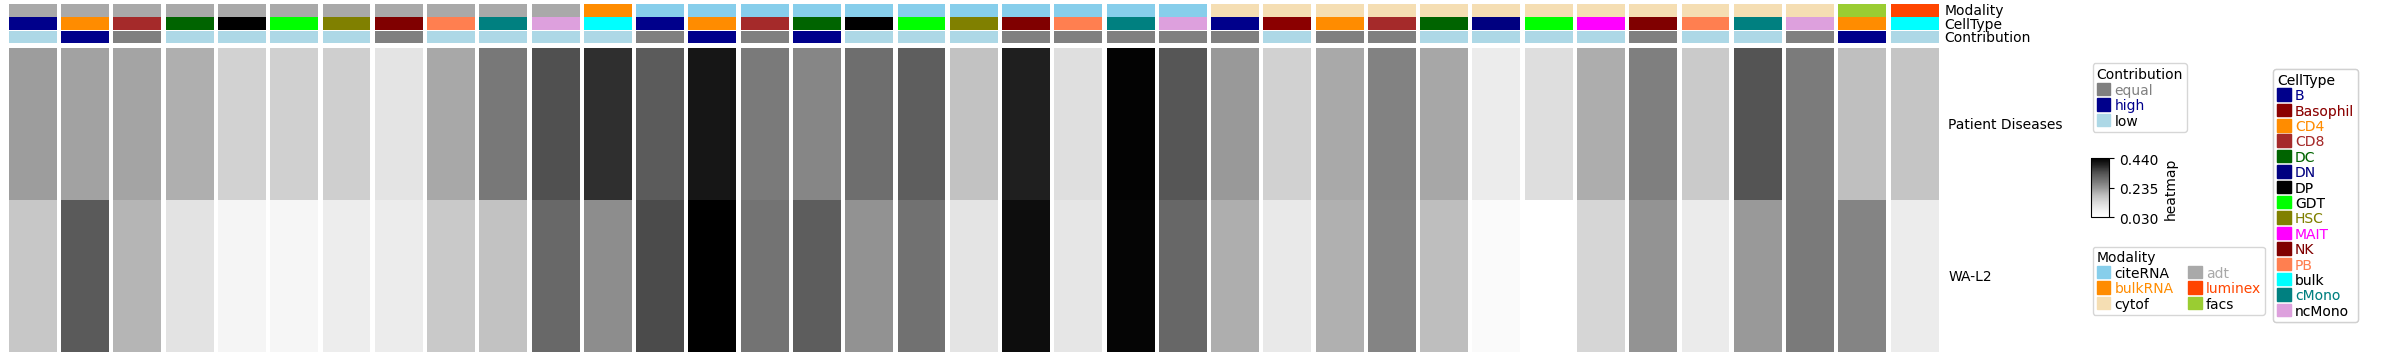

In [ ]:
contribution_differences = []
df = pd.DataFrame(ami_knn, index = ["gt", "wa"], columns = list(level2_knn_PSNs.keys()))

for col in df.columns:
    gt_cont = df.loc["gt", col]
    wa_cont = df.loc["wa", col]
    contribution_differences.append(abs(gt_cont - wa_cont))

tolerance = np.percentile(contribution_differences, 35)
contribution = []


for col in df.columns:
    gt_cont = df.loc["gt", col]
    wa_cont = df.loc["wa", col]
    if abs(gt_cont - wa_cont) <= tolerance:
        contribution.append("equal")
    elif gt_cont > wa_cont:
        contribution.append("low")
    elif gt_cont < wa_cont:
        contribution.append("high")



number_to_modality = {}
number_to_contribution = {}
number_to_cell_type = {}


for i, id in enumerate(level2_knn_PSNs.keys()):

    number_to_modality[i] = level2_graphs[id].uns["modality"]
    number_to_contribution[i] = contribution[i]
    number_to_cell_type[i] = level2_graphs[id].uns["cell-type"]


df_column = pd.DataFrame(number_to_modality.values(), columns=["modality"] ).join(pd.DataFrame(number_to_contribution.values(), columns=["contribution"])).join(pd.DataFrame(number_to_cell_type.values(), columns=["cell_type"]))


col_colors_dict = {"modality":{"citeRNA":"skyblue", "bulkRNA": "darkorange" , "cytof": "wheat", "adt": "darkgray", "luminex": "orangered", "facs": "yellowgreen"},
                  "contribution":{"equal": "grey", "high": "darkblue", "low":"lightblue"},
                  "cell_type":{"B":"darkblue", "Basophil": "darkred" , "CD4": "darkorange", "CD8": "brown", "DC": "darkgreen", "DN": "navy", "DP":"black", 'GDT':"lime", 'HSC': "olive", 'MAIT': "fuchsia", 'NK': "maroon", 'PB':"coral", 'bulk':"aqua", 'cMono':"teal", 'ncMono':"plum" }   }


col_ha= HeatmapAnnotation(Modality=anno_simple(df_column.modality,colors=col_colors_dict['modality'],rasterized=True),
                          CellType=anno_simple(df_column.cell_type,colors=col_colors_dict['cell_type'],rasterized=True),
                          Contribution=anno_simple(df_column.contribution,colors=col_colors_dict['contribution'],rasterized=True),
                          axis=1)


fig, ax = plt.subplots(figsize=(25,4))
df = pd.DataFrame(ami_knn, index = ["Patient Diseases", "WA-L2"],  columns = list(number_to_modality.keys())) # Data Frame containing normalized data for each score
ami_kernel_plt = ClusterMapPlotter(df, top_annotation=col_ha,
                     show_rownames=True,show_colnames=False,
                     row_dendrogram=False,col_dendrogram=False,
                     col_split=df_column.loc[:, [ 'modality', "cell_type", 'contribution']],
                     cmap='Greys',
                     rasterized=True,col_split_gap=1.2,legend=True,legend_anchor='ax_heatmap',legend_vpad=5,legend_hpad= 8, row_split_gap=1.2 )

In [ ]:
sum((df.loc["Patient Diseases"]>0.3 ) * 1)

9

In [ ]:
fig.savefig(os.path.join(write_path, "WA2-cont"))

In [ ]:
contribution_map = {}
for idx, val in enumerate(ami_knn[1]):
    contribution_map[list(level2_graphs.keys())[idx]]= val

contribution_map = {k: v for k, v in sorted(contribution_map.items(), key=lambda item: item[1])} 


high_contributors = []
high_cont_graph_ids_wa = []
for i in range(10):
    id = list(contribution_map.keys())[-i-1]
    high_cont_graph_ids_wa.append(id)
    name = id_to_name[id]
    print(name)
    high_contributors.append(name)
    modality = name.split("_")[0]

citeRNA_CD4_L2
citeRNA_cMono_L2
citeRNA_NK_L2
citeRNA_B_L2
adt_CD4_L2
citeRNA_DC_L2
citeRNA_ncMono_L2
adt_ncMono_L2
citeRNA_GDT_L2
citeRNA_CD8_L2


In [ ]:
with open(os.path.join(write_path, 'wa2_names.pickle'), 'wb') as f:
    pickle.dump(high_contributors, f)

### WA-L3

In [ ]:
knn_labels = {"ground_truth": list(gt_d.values()) , "wa": level3_cluster_info["fused_knn_frequency"]} 
for id, matrix in level3_knn_PSNs.items():
     knn_labels = knn_labels | {id: cluster.spectral_clustering(matrix, n_clusters=first)}


nmi = metrics.nmi(list(knn_labels.values()))
ami_knn = nmi[:2, 2:]

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..


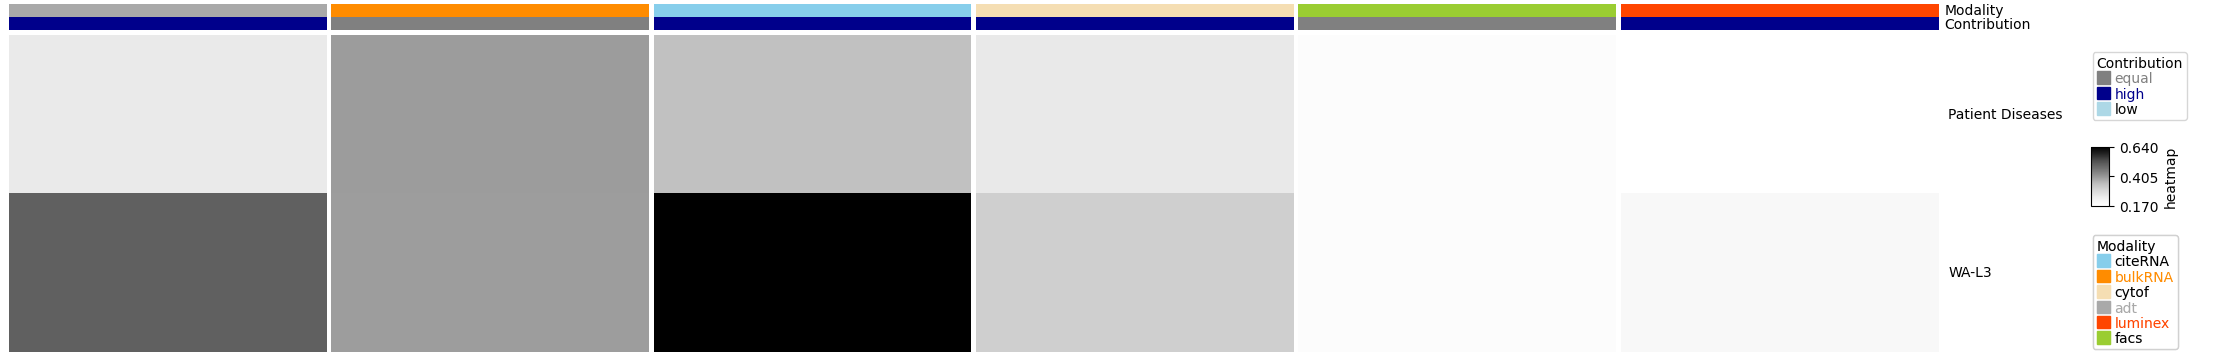

In [ ]:
contribution_differences = []
df = pd.DataFrame(ami_knn, index = ["gt", "wa"], columns = list(level3_knn_PSNs.keys()))

for col in df.columns:
    gt_cont = df.loc["gt", col]
    wa_cont = df.loc["wa", col]
    contribution_differences.append(abs(gt_cont - wa_cont))

tolerance = np.percentile(contribution_differences, 35)
contribution = []


for col in df.columns:
    gt_cont = df.loc["gt", col]
    wa_cont = df.loc["wa", col]
    if abs(gt_cont - wa_cont) <= tolerance:
        contribution.append("equal")
    elif gt_cont > wa_cont:
        contribution.append("low")
    elif gt_cont < wa_cont:
        contribution.append("high")



number_to_modality = {}
number_to_contribution = {}


for i, id in enumerate(level3_knn_PSNs.keys()):

    number_to_modality[i] = level3_graphs[id].uns["modality"]
    number_to_contribution[i] = contribution[i]


df_column = pd.DataFrame(number_to_modality.values(), columns=["modality"] ).join(pd.DataFrame(number_to_contribution.values(), columns=["contribution"]))


col_colors_dict = {"modality":{"citeRNA":"skyblue", "bulkRNA": "darkorange" , "cytof": "wheat", "adt": "darkgray", "luminex": "orangered", "facs": "yellowgreen"},
                  "contribution":{"equal": "grey", "high": "darkblue", "low":"lightblue"}  }


col_ha= HeatmapAnnotation(Modality=anno_simple(df_column.modality,colors=col_colors_dict['modality'],rasterized=True),
                          Contribution=anno_simple(df_column.contribution,colors=col_colors_dict['contribution'],rasterized=True),
                          axis=1)


fig, ax = plt.subplots(figsize=(25,4))
df = pd.DataFrame(ami_knn, index = ["Patient Diseases", "WA-L3"],  columns = list(number_to_modality.keys())) # Data Frame containing normalized data for each score
ami_kernel_plt = ClusterMapPlotter(df, top_annotation=col_ha,
                     show_rownames=True,show_colnames=False,
                     row_dendrogram=False,col_dendrogram=False,
                     col_split=df_column.loc[:, [ 'modality', 'contribution']],
                     cmap='Greys',
                     rasterized=True,col_split_gap=1.2,legend=True,legend_anchor='ax_heatmap',legend_vpad=5,legend_hpad= 8, row_split_gap=1.2 )

In [ ]:
fig.savefig(os.path.join(write_path, "WA3-cont"))

In [ ]:
sum((df.loc["Patient Diseases"]>0.3 ) * 1)

2